# CNN na przykładzie MNIST

# Setup
Importujemy potrzebne biblioteki

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# 1 Przygotowanie danych

## 1.0 Pobranie zbioru danych
Pobieramy zbiór danych i sprawdzamy rozmiar 28 x 28 pixeli.

In [2]:
(x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.fashion_mnist.load_data()

dataset_labels = ["0",  # index 0
                  "1",  # index 1
                  "2",  # index 2
                  "3",  # index 3
                  "4",  # index 4
                  "5",  # index 5
                  "6",  # index 6
                  "7",  # index 7
                  "8",  # index 8
                  "9"]  # index 9

print("x_train shape:", x_train_data.shape, "y_train shape:", y_train_data.shape)
print("x_test shape:", x_test_data.shape, "y_test shape:", y_test_data.shape)

4422102/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


## 1.1 Wizualizacja danych
Przykładowy obrazek ze bioru danych

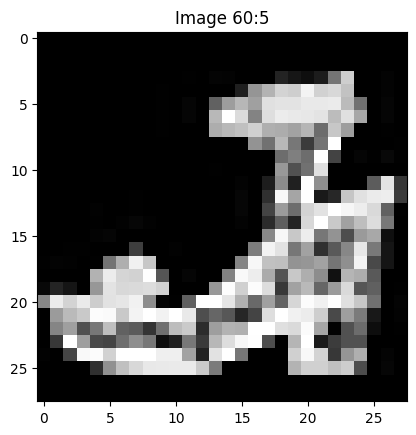

In [3]:
def plot_image(img_index):
    label_index = y_train_data[img_index]
    plt.imshow(x_train_data[img_index]/255, cmap = 'gray')
    plt.title("Image "+str(img_index)+":"+dataset_labels[label_index])

img_index = 60
plot_image(img_index)

## 1.2 Normalizacja danych
Na początek sprawdzamy jakie są max i min wartości pixeli w obrazkach.

Wartości te powinny być zawarte w przedziale [0,1].

In [4]:
print("Wartości min:",np.min(x_train_data)," max:",np.max(x_train_data))

x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255

print("Wartości po przeskalowaniu min:",np.min(x_train_data)," max:",np.max(x_train_data))


Wartości min: 0  max: 255
Wartości po przeskalowaniu min: 0.0  max: 1.0


## 1.3 Podział zbioru danych na zbiór treningowy/walidacyjny/testowy
*   **Zbiór treningowy** - wykorzystamy go do uczenia.
*   **Zbiór walidacyjny** - wykorzystamy go do tuningu hiperparametrów.
*   **Zbiór testowy** - wykorzystamy go do ostatecznego sprawdzenia modelu.

Zbiór walidacyjny stworzymy z 10% zbioru treningowego.

In [5]:
validation_fraction = .1

total_train_samples = len(x_train_data)
validation_samples = int(total_train_samples * validation_fraction)
train_samples = total_train_samples - validation_samples

(x_train, x_valid) = x_train_data[:train_samples], x_train_data[train_samples:]
(y_train, y_valid) = y_train_data[:train_samples], y_train_data[train_samples:]

x_test, y_test = x_test_data, y_test_data
print(train_samples, validation_samples, len(x_test))

54000 6000 10000


## 1.4 Dwa dodatkowe kroki
1. Większość zestawów danych obrazu składa się z obrazów rgb. Z tego powodu Keras oczekuje, że każdy obraz będzie miał 3 wymiary: [x_pixels, y_pixels, color_channels]. Ponieważ nasze obrazki są w skali szarości, wymiar koloru jest równy 1. Musimy zatem zmienić kształt obrazków.

2. W procesie uczenia naszego modelu będziemy wykorzystwali tzw. **kategoryczną entropię krzyżową** (https://keras.io/losses/). Musimy przekształcić wektory z etykietami (labelami) do **kodowania one-hot**. Wykorzystamy do tego funkcję tf.keras.utils.to_categorical().

In [6]:
# Zmieniamy kształ z (28, 28) na (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# Kodowanie one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Ilość elmentów w zbiorach
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')


x_train shape: (54000, 28, 28, 1) y_train shape: (54000, 10)
54000 train set
6000 validation set
10000 test set


# 2 Stworzenie modelu

Keras oferuje dwa API:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/models/model/)

W naszym modelu wykorzystamy Sequential model API. Będziemy wykorzystwali następujące metody:

*   Dense()    [link text](https://keras.io/layers/core/) - tworzy **warstwę gęstą**
*   Conv2D()   [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - tworzy **warstwę konwolucyjną**
*   Pooling()  [link text](https://keras.io/layers/pooling/) - tworzy **warstwę pooling**
*   Dropout()  [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - zastowanie **dropout**

## 2.0 Prosty model liniowy
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera adam**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [8]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???


## Uczenie modelu

Model uczymy wykorzystując fit().

In [9]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 5, validation_data = (x_valid,y_valid))

Epoch 1/5
844/844 [==============================] - 11s 10ms/step - loss: 0.6659 - accuracy: 0.7815 - val_loss: 0.5227 - val_accuracy: 0.8168
Epoch 2/5
844/844 [==============================] - 5s 6ms/step - loss: 0.4892 - accuracy: 0.8341 - val_loss: 0.4733 - val_accuracy: 0.8378
Epoch 3/5
844/844 [==============================] - 3s 3ms/step - loss: 0.4558 - accuracy: 0.8447 - val_loss: 0.4471 - val_accuracy: 0.8448
Epoch 4/5
844/844 [==============================] - 3s 4ms/step - loss: 0.4362 - accuracy: 0.8511 - val_loss: 0.4455 - val_accuracy: 0.8442
Epoch 5/5
844/844 [==============================] - 2s 3ms/step - loss: 0.4250 - accuracy: 0.8549 - val_loss: 0.4297 - val_accuracy: 0.8505


Wykresy precyzji i błędu

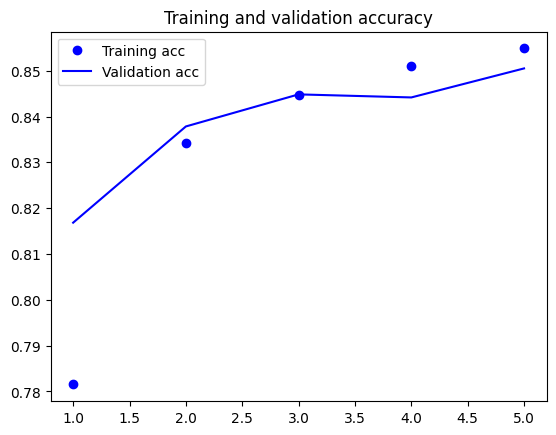

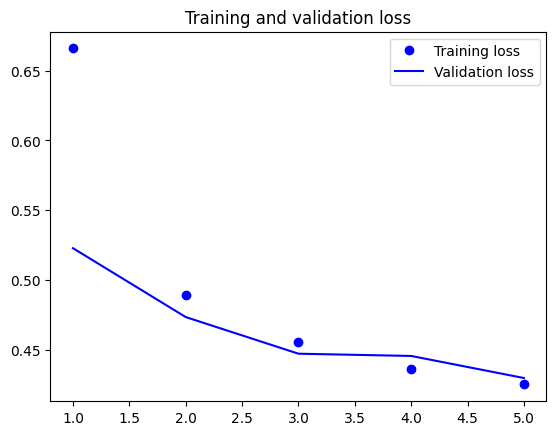

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [11]:
model.save("mnist_simple.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Wczytanie modelu

In [12]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [13]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.8393999934196472


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 1s 1ms/step


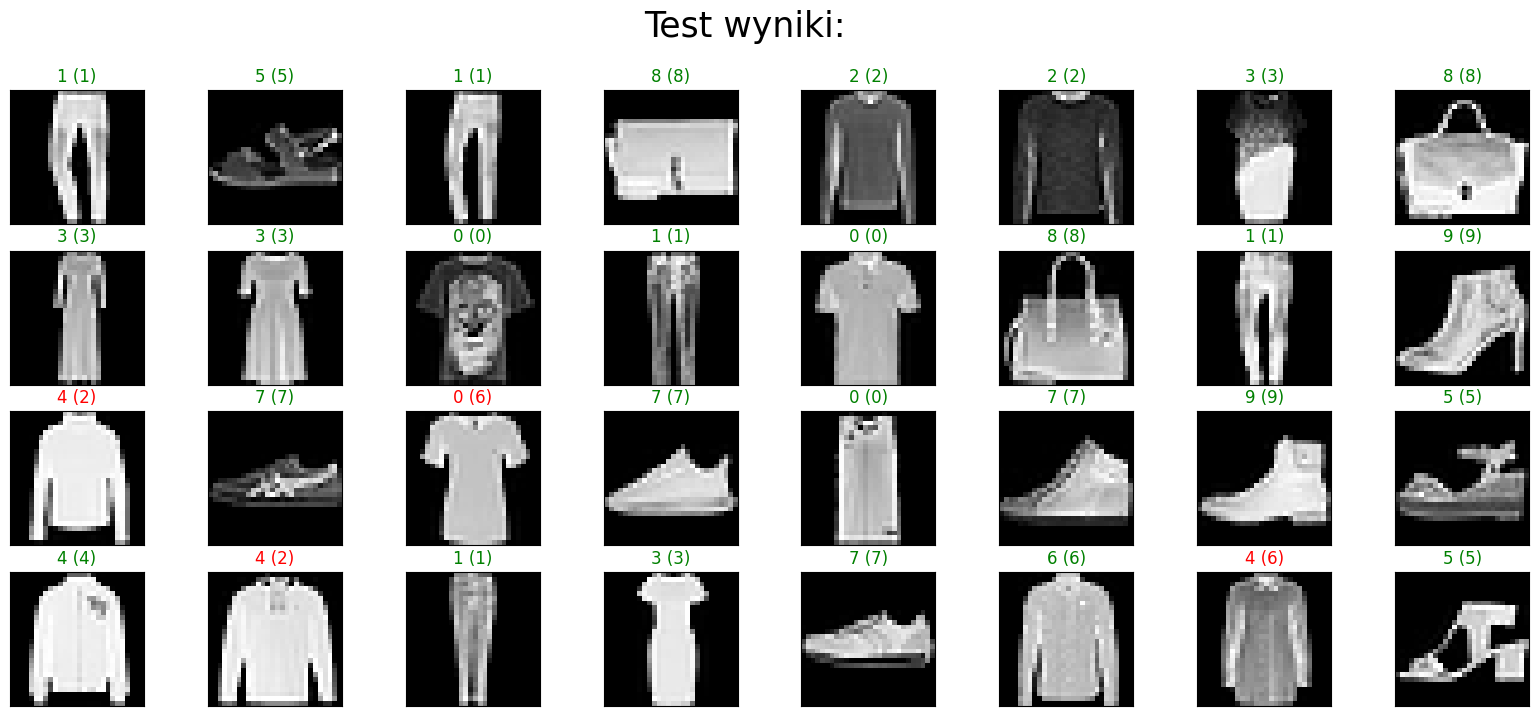

In [14]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



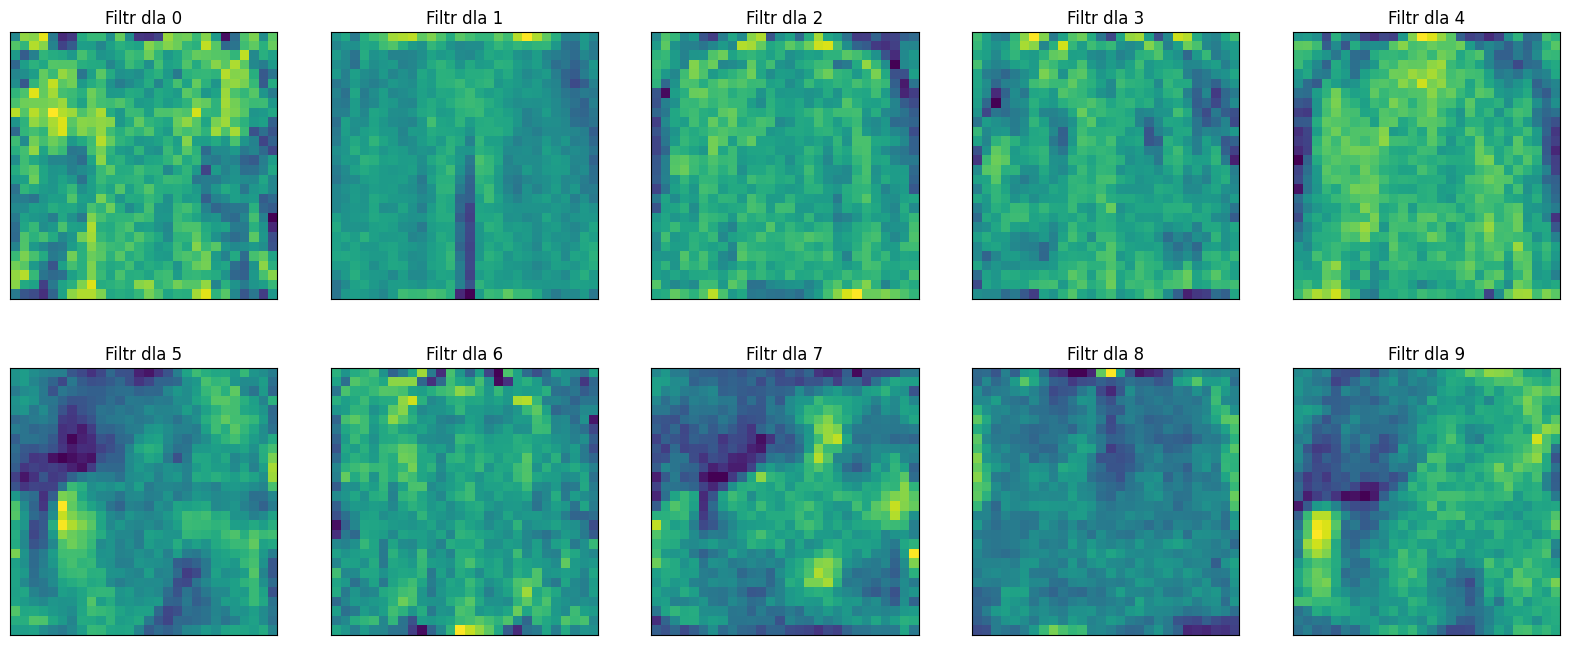

In [15]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

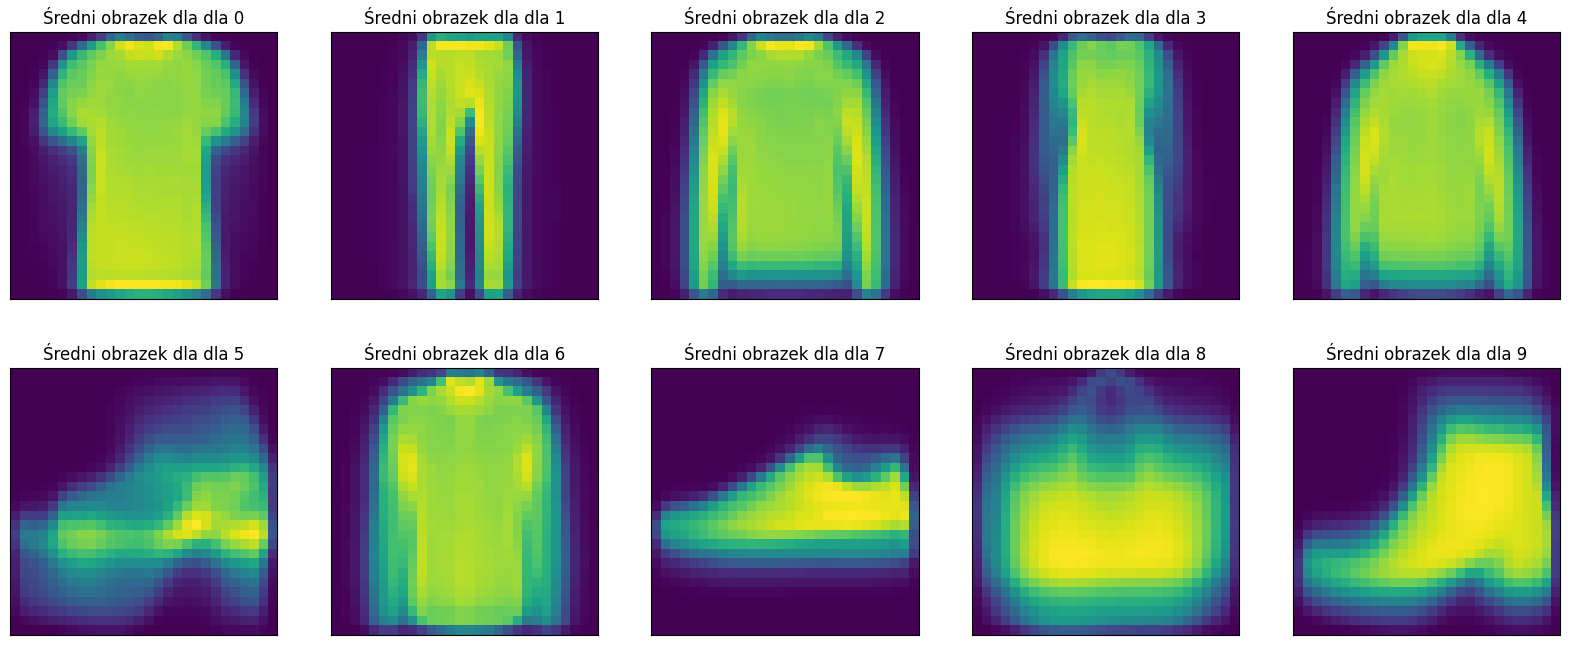

In [16]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


## 2.0 Prosty model liniowy v2
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera adam**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???


## Uczenie modelu

Model uczymy wykorzystując fit().

In [19]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 5, validation_data = (x_valid,y_valid))

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5608 - accuracy: 0.8092 - val_loss: 0.4680 - val_accuracy: 0.8358
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4523 - accuracy: 0.8437 - val_loss: 0.4662 - val_accuracy: 0.8410
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4311 - accuracy: 0.8516 - val_loss: 0.4286 - val_accuracy: 0.8487
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4212 - accuracy: 0.8538 - val_loss: 0.4370 - val_accuracy: 0.8490
Epoch 5/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4146 - accuracy: 0.8562 - val_loss: 0.4180 - val_accuracy: 0.8540


Wykresy precyzji i błędu

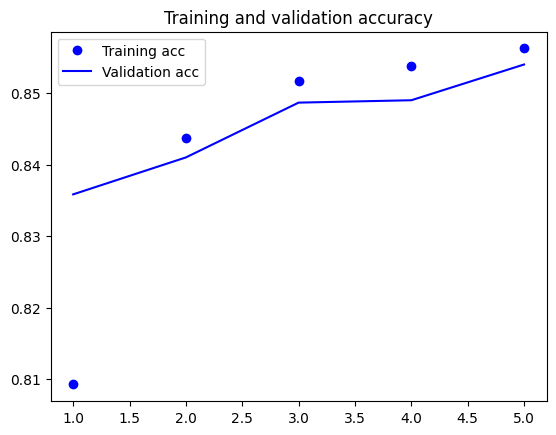

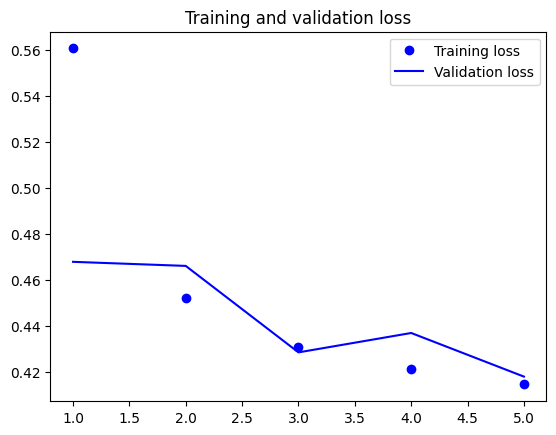

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [21]:
model.save("mnist_simple.h5")

Wczytanie modelu

In [22]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [23]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.8410999774932861


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 0s 1ms/step


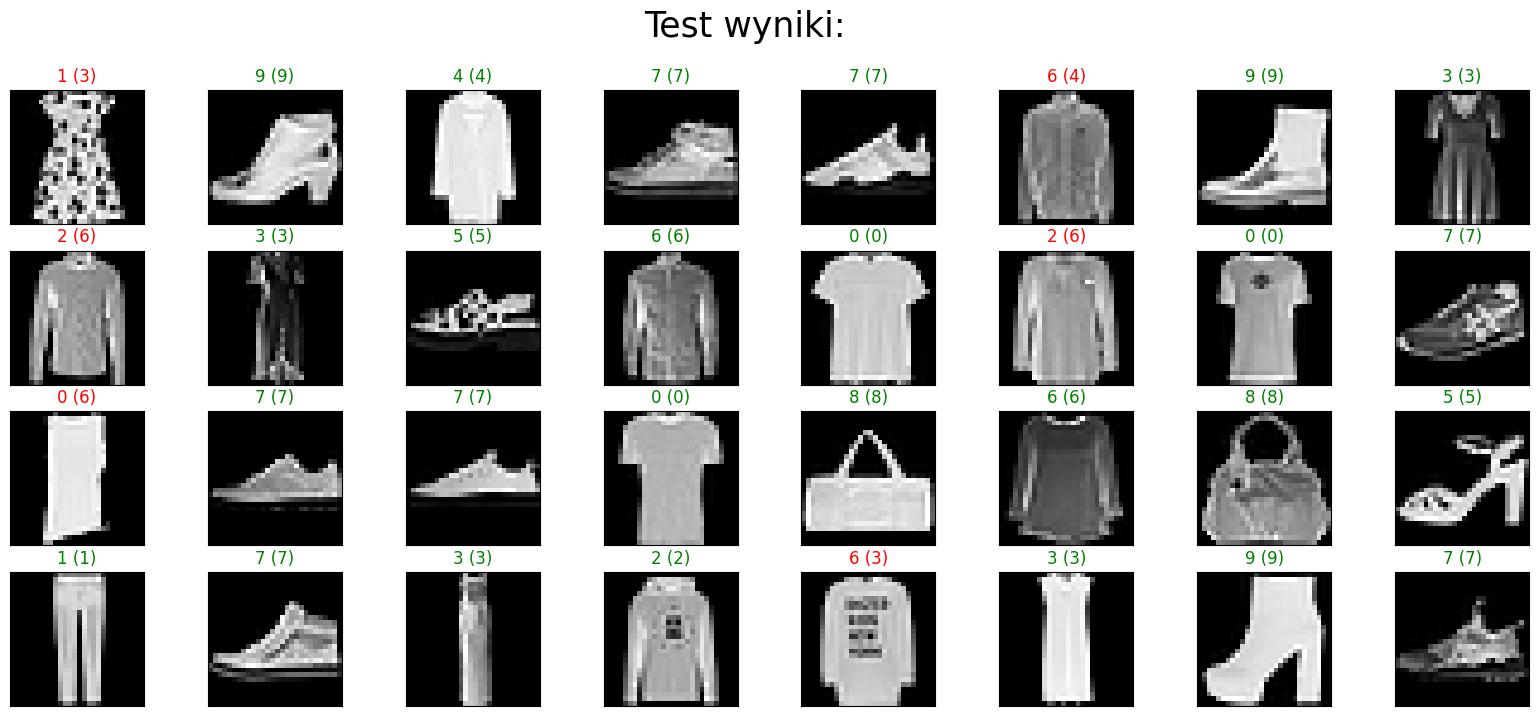

In [24]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



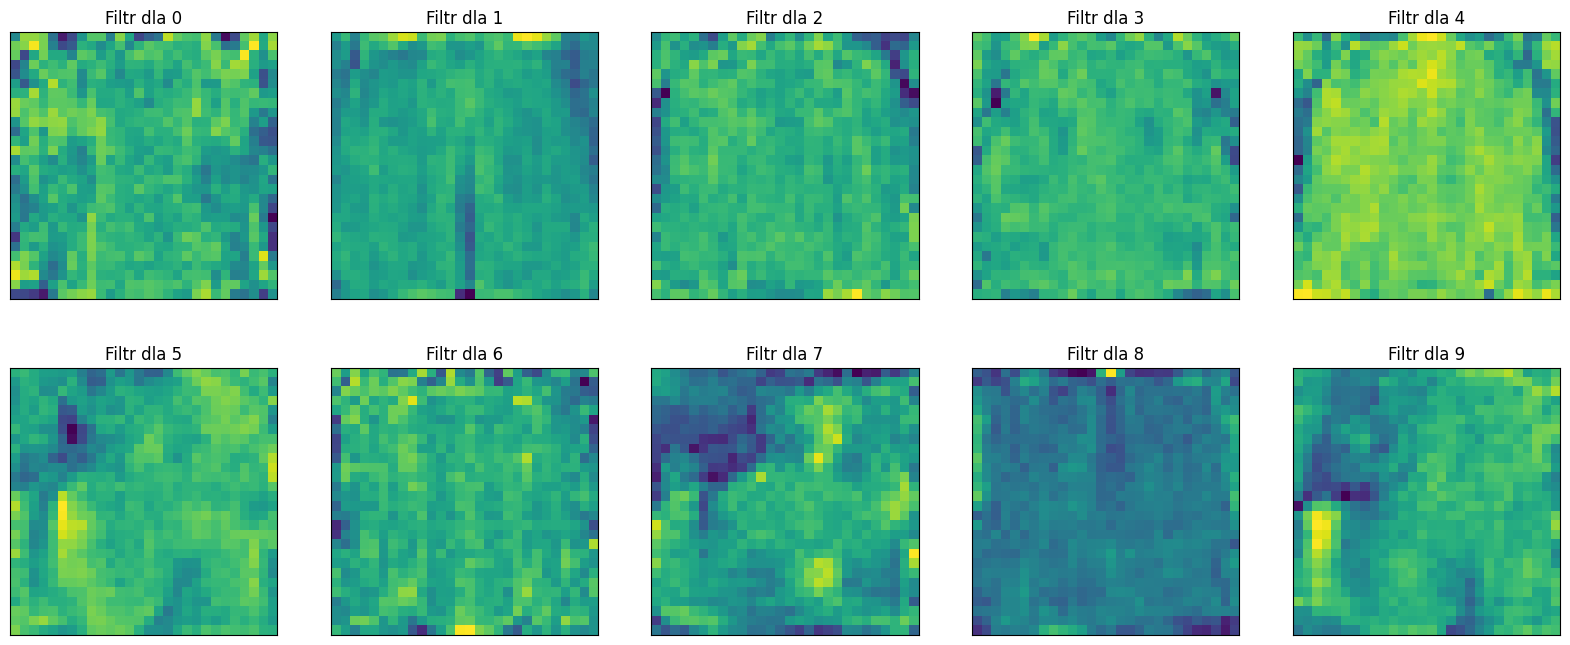

In [25]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

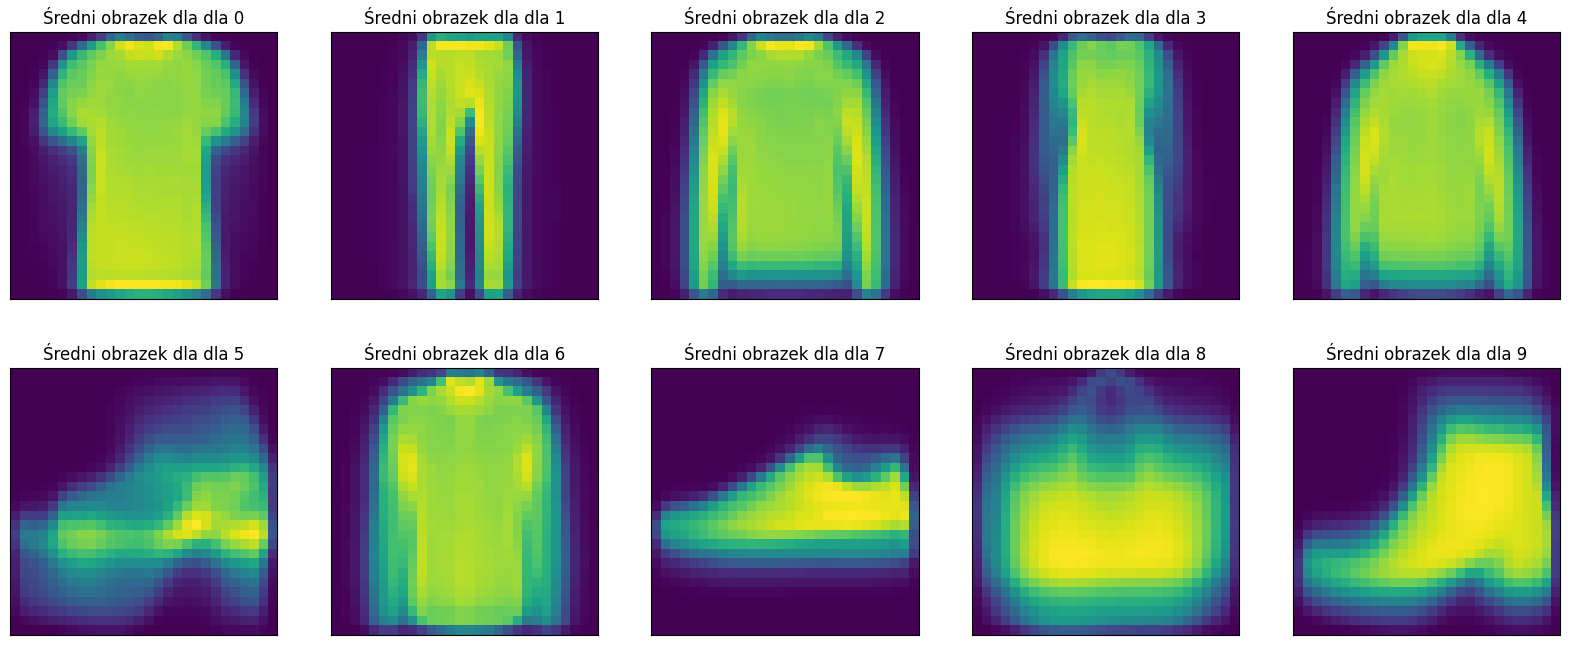

In [26]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


## 2.0 Prosty model liniowy v3
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [27]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera sgd**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [28]:
opt = keras.optimizers.SGD(learning_rate=0.04)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Uczenie modelu

Model uczymy wykorzystując fit().

In [29]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 75, validation_data = (x_valid,y_valid))

Epoch 1/75
844/844 [==============================] - 3s 3ms/step - loss: 0.7270 - accuracy: 0.7649 - val_loss: 0.5649 - val_accuracy: 0.8130
Epoch 2/75
844/844 [==============================] - 2s 3ms/step - loss: 0.5413 - accuracy: 0.8208 - val_loss: 0.5123 - val_accuracy: 0.8275
Epoch 3/75
844/844 [==============================] - 3s 4ms/step - loss: 0.5032 - accuracy: 0.8314 - val_loss: 0.4862 - val_accuracy: 0.8315
Epoch 4/75
844/844 [==============================] - 2s 3ms/step - loss: 0.4818 - accuracy: 0.8379 - val_loss: 0.4780 - val_accuracy: 0.8353
Epoch 5/75
844/844 [==============================] - 2s 3ms/step - loss: 0.4683 - accuracy: 0.8419 - val_loss: 0.4647 - val_accuracy: 0.8360
Epoch 6/75
844/844 [==============================] - 2s 3ms/step - loss: 0.4573 - accuracy: 0.8459 - val_loss: 0.4500 - val_accuracy: 0.8410
Epoch 7/75
844/844 [==============================] - 2s 3ms/step - loss: 0.4505 - accuracy: 0.8476 - val_loss: 0.4516 - val_accuracy: 0.8415
Epoch 

Wykresy precyzji i błędu

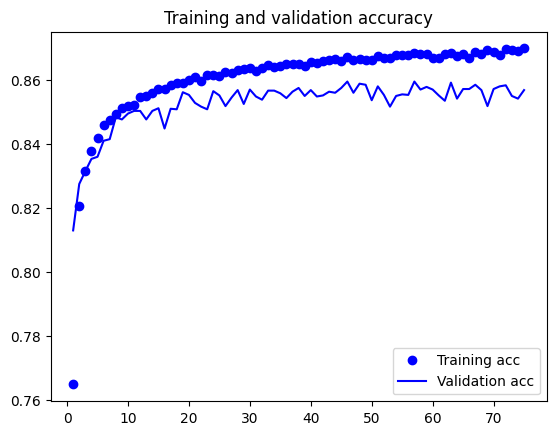

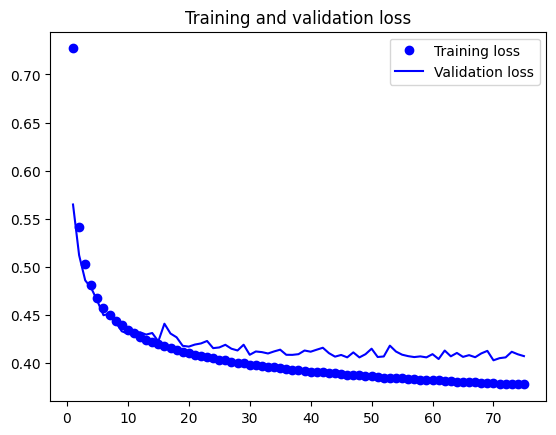

In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [31]:
model.save("mnist_simple.h5")

Wczytanie modelu

In [32]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [33]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.8434000015258789


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 0s 1ms/step


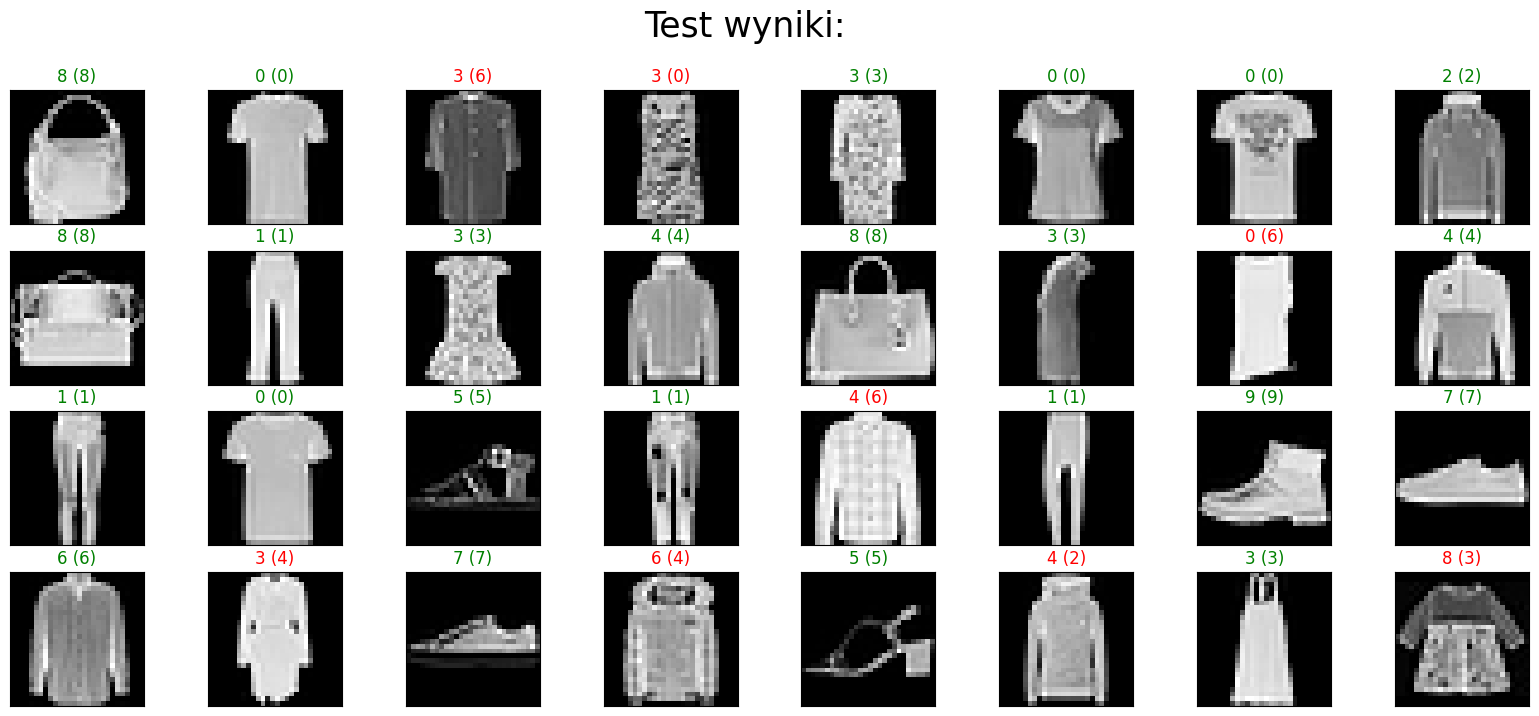

In [34]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



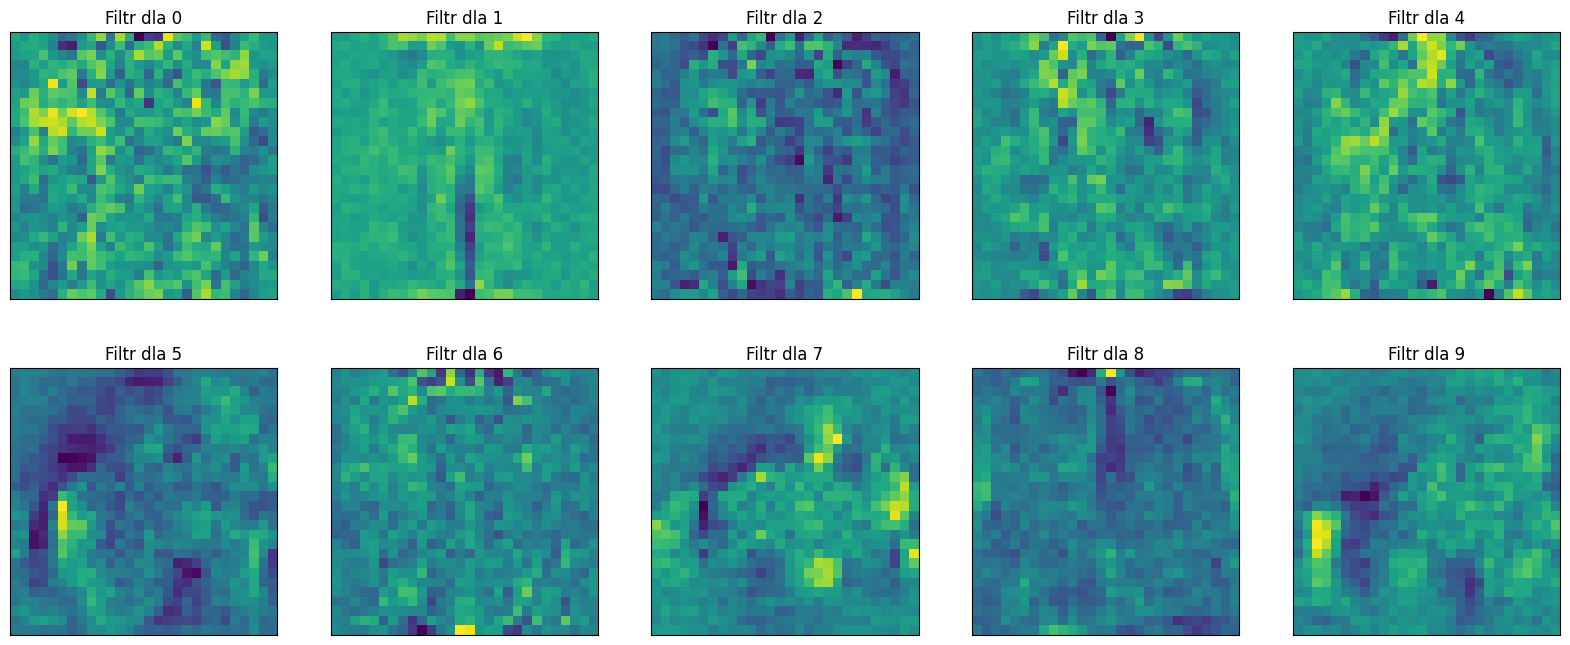

In [35]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

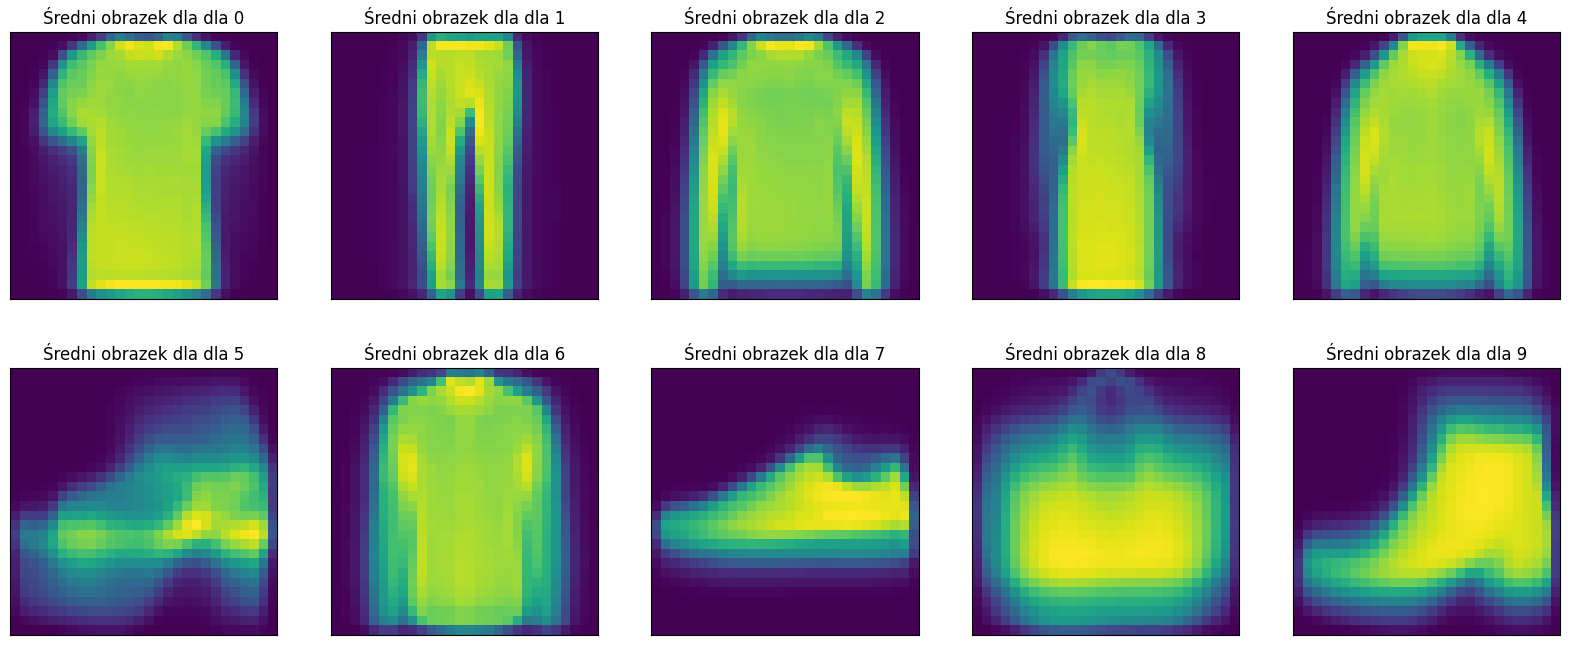

In [36]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


# 2.1 A teraz sieć neuronowa
Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [37]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(60,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 60)                47100     
                                                                 
 dense_4 (Dense)             (None, 10)                610       
                                                                 
Total params: 47710 (186.37 KB)
Trainable params: 47710 (186.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
844/844 [==============================] - 4s 3ms/step - loss: 0.5653 - accuracy: 0.8077 - val_loss: 0.4265 - val_accuracy: 0.8442
Epoch 2/10
844/844 [==============================] - 4s 4ms/step - loss: 0.4121 - accuracy: 0.8532 - val_loss: 0.4095 - val_accuracy: 0.8

Precyzja

In [38]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.8726999759674072


Wykresy precyzji i błędu

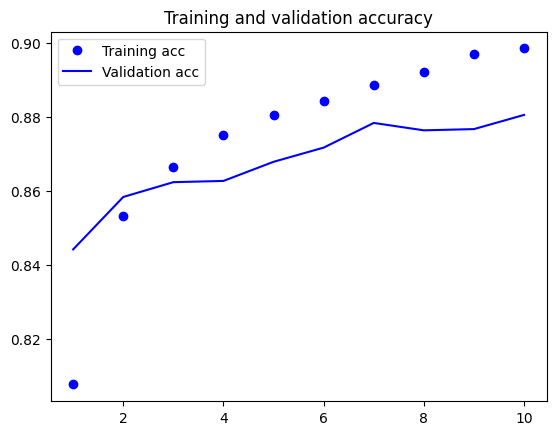

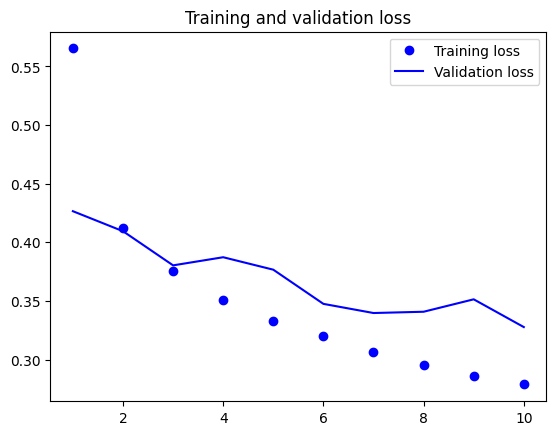

In [39]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 1s 2ms/step


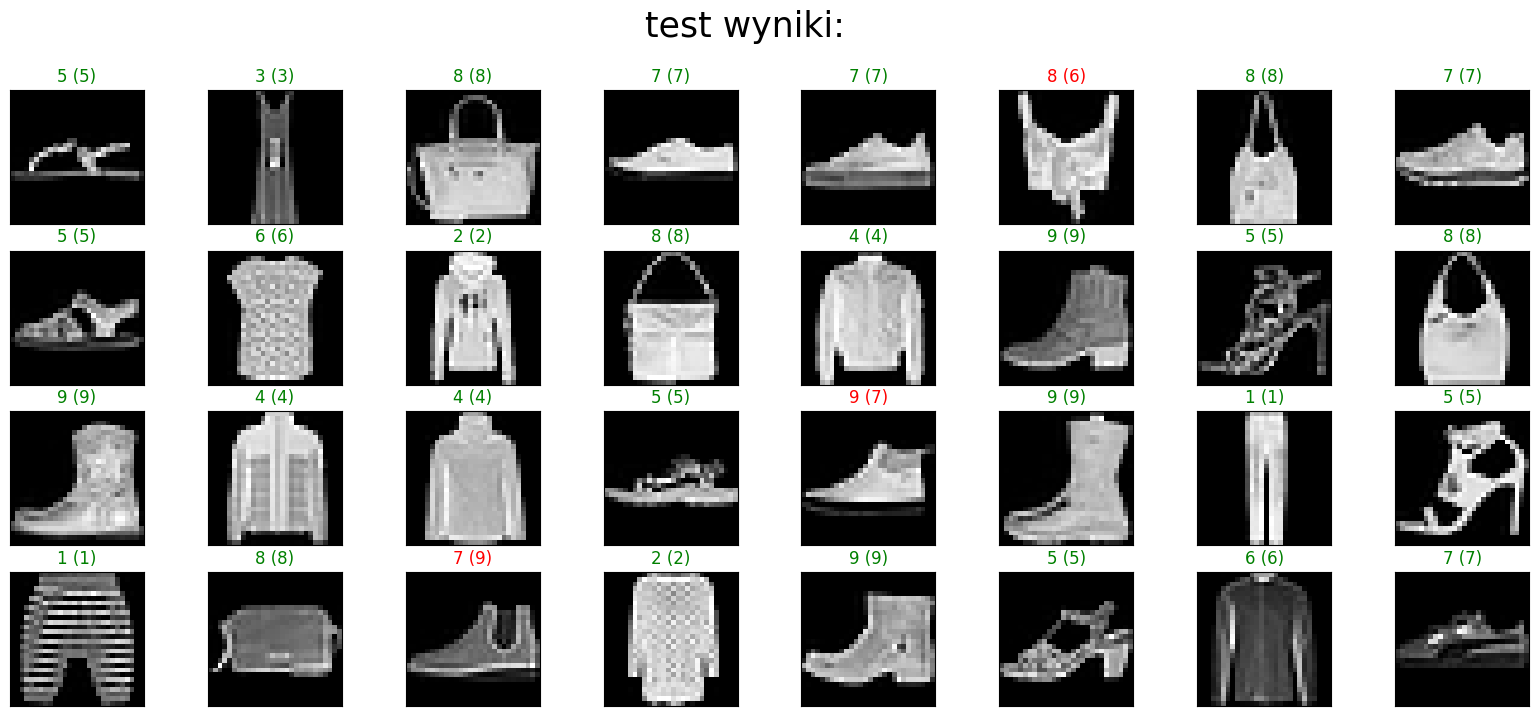

In [40]:
visualize_model_predictions(model, x_test, y_test, "test" )

# 2.1 Sieć neuronowa v2
Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [41]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
opt = keras.optimizers.Adam(learning_rate=0.004)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???

history = model.fit(x_train, y_train, batch_size = 64, epochs = 13, validation_data = (x_valid,y_valid))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/13
844/844 [==============================] - 4s 4ms/step - loss: 0.4945 - accuracy: 0.8241 - val_loss: 0.3975 - val_accuracy: 0.8548
Epoch 2/13
844/844 [==============================] - 3s 3ms/step - loss: 0.3838 - accuracy: 0.8597 - val_loss: 0.3851 - val_accuracy: 0.8

Precyzja

In [42]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.8708999752998352


Wykresy precyzji i błędu

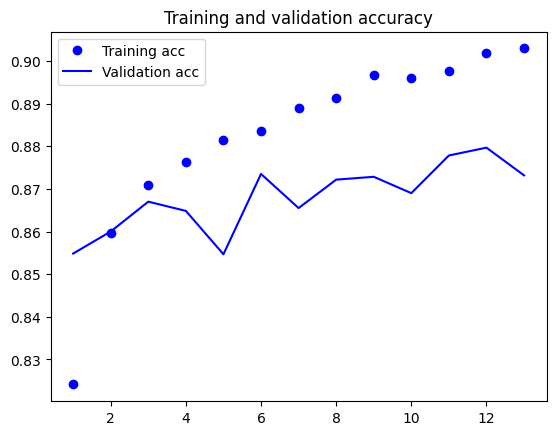

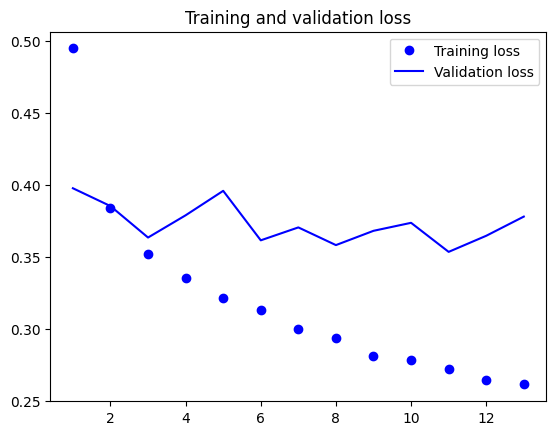

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 1s 1ms/step


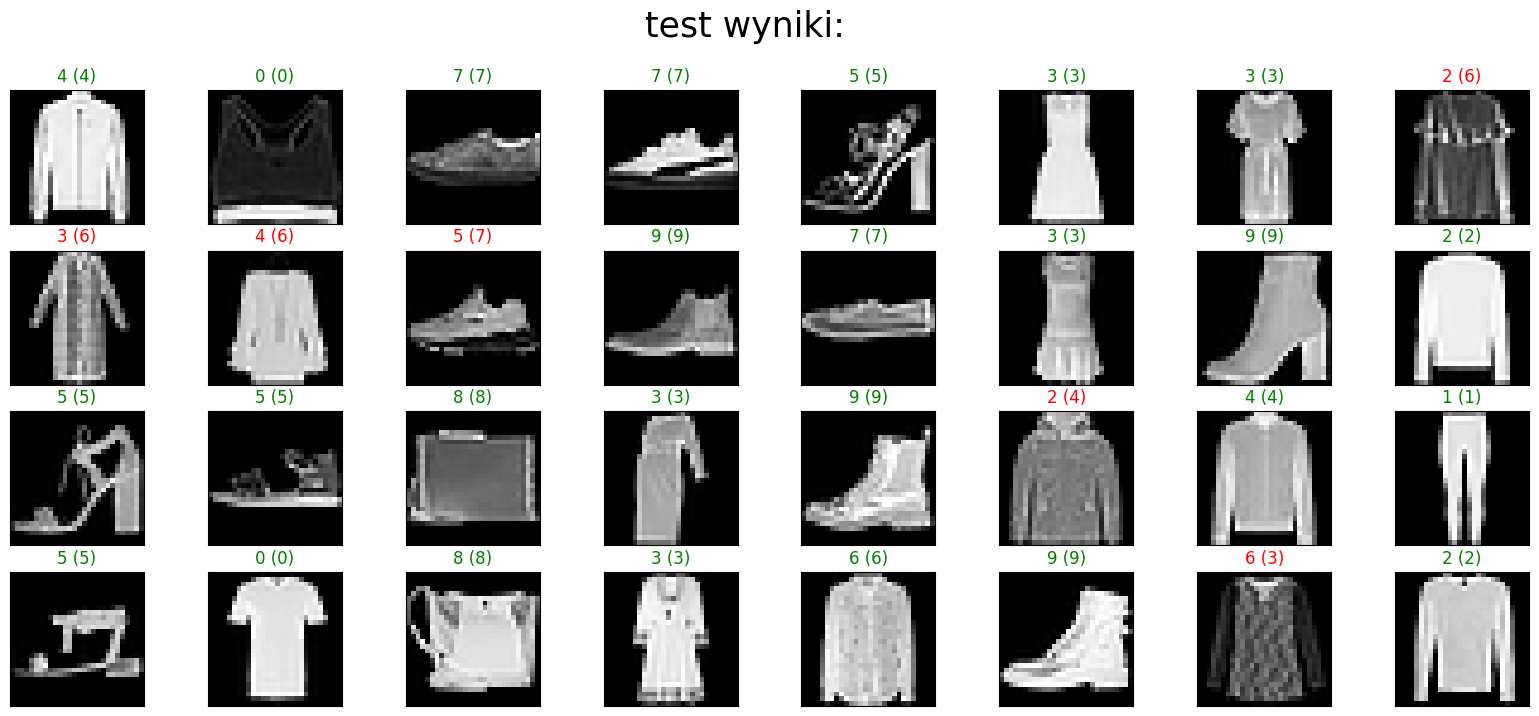

In [44]:
visualize_model_predictions(model, x_test, y_test, "test" )

# 2.1 Sieć neuronowa v3

Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [45]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
opt = keras.optimizers.SGD(learning_rate=0.08)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 128, epochs = 50, validation_data = (x_valid,y_valid))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                50240     
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
422/422 [==============================] - 2s 4ms/step - loss: 0.7049 - accuracy: 0.7631 - val_loss: 0.5236 - val_accuracy: 0.8170
Epoch 2/50
422/422 [==============================] - 2s 4ms/step - loss: 0.4884 - accuracy: 0.8301 - val_loss: 0.4657 - val_accuracy: 0.8

Precyzja

In [46]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.8774999976158142


Wykresy precyzji i błędu

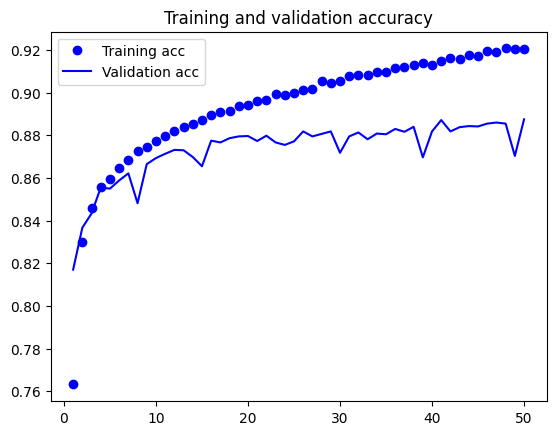

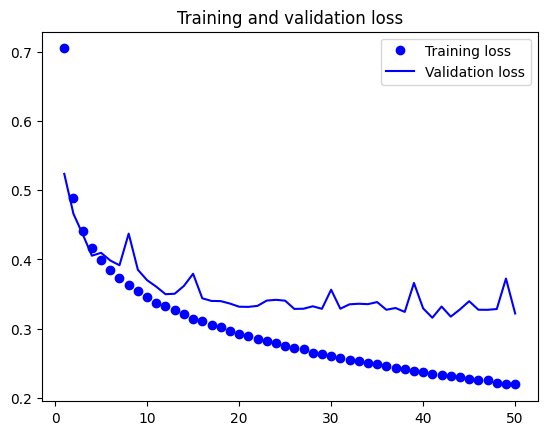

In [47]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 1s 2ms/step


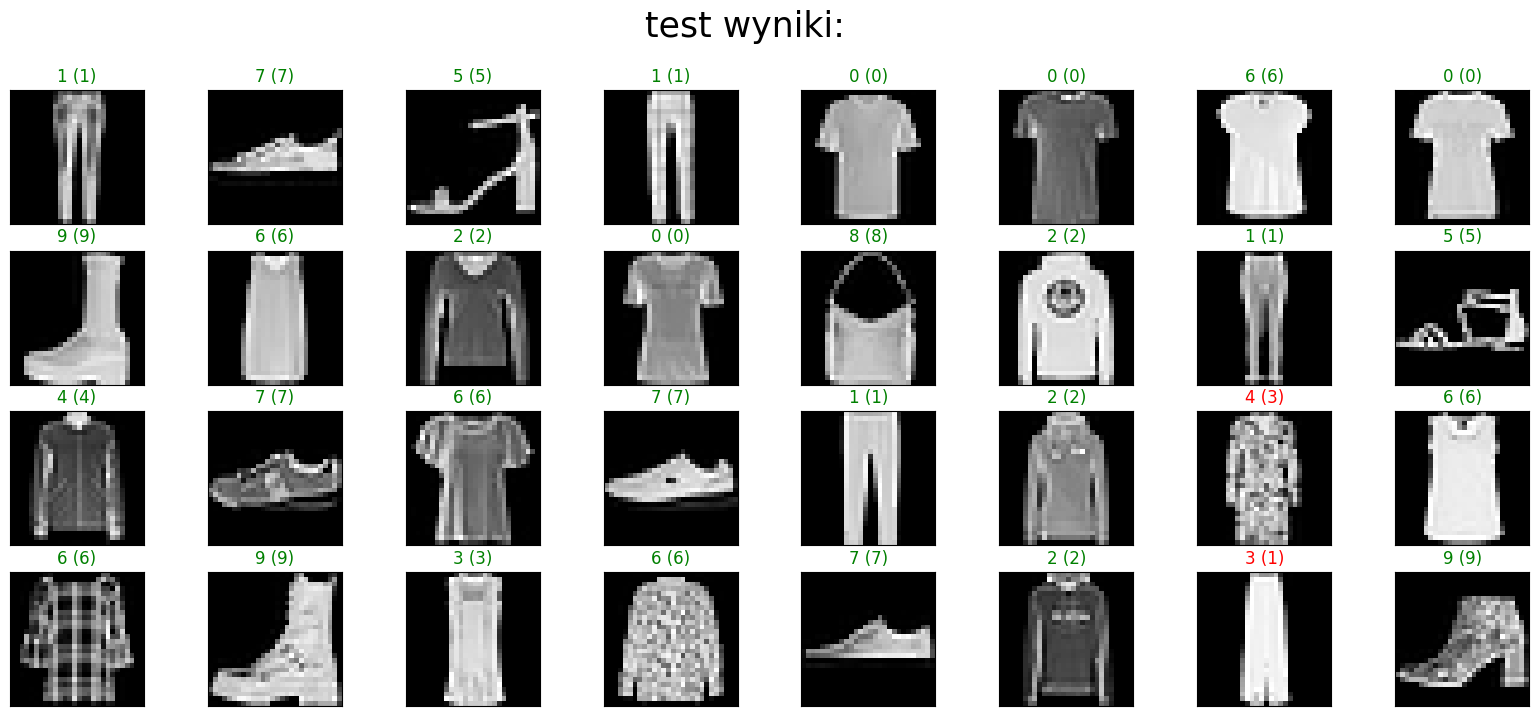

In [48]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Spróbujmy pogłębić nasz model!
Dodajmy 3 warstwy gęste.

In [49]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 115306 (450.41 KB)
Trainable params: 115

Wykresy precyzji i błędu

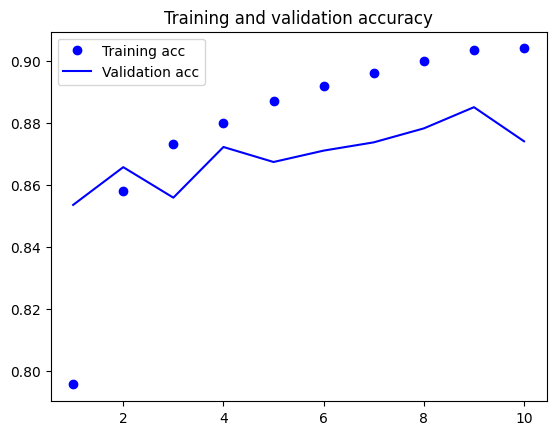

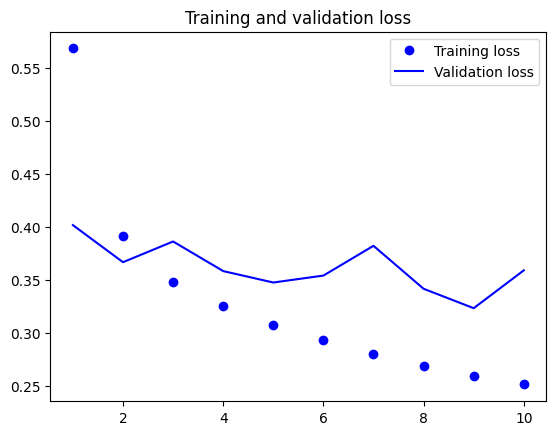

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


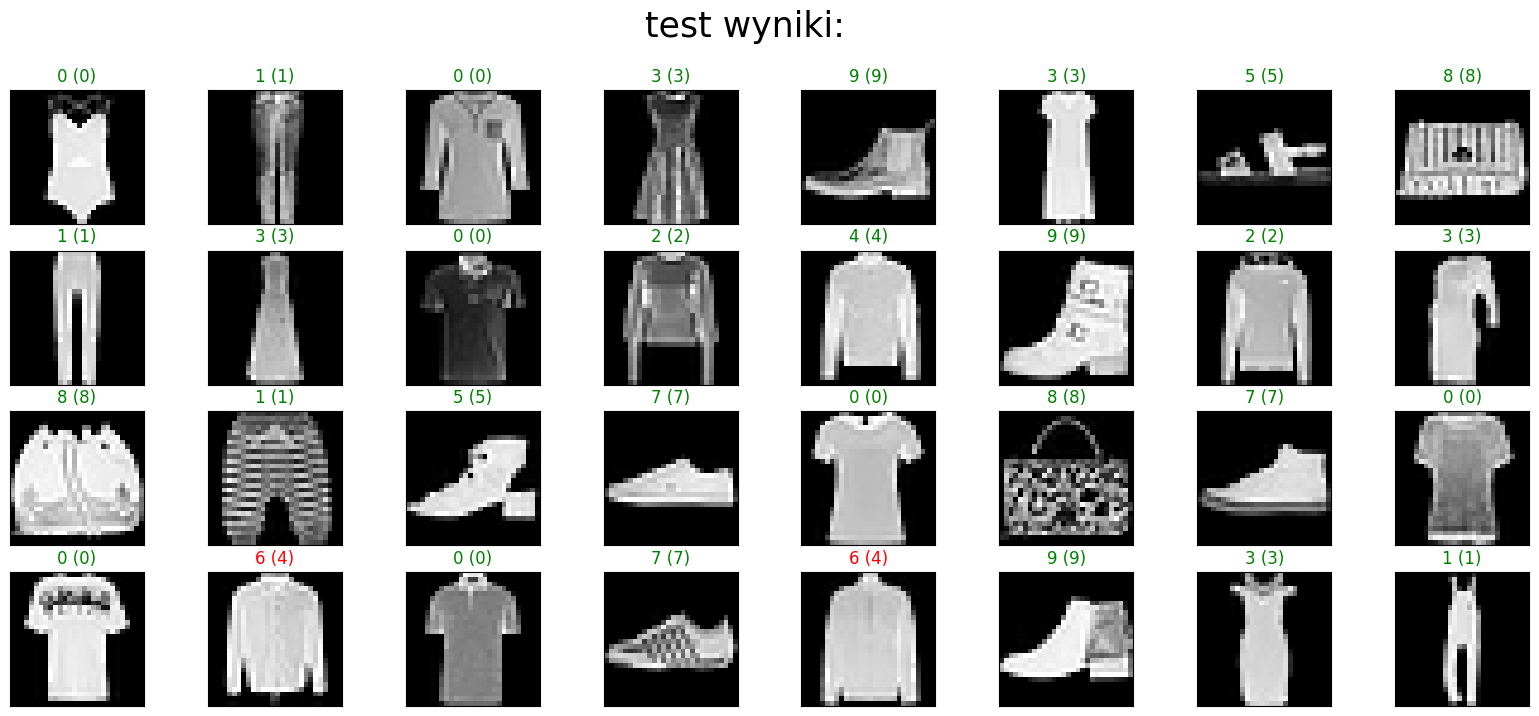

In [51]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Pogłębinienie modelu v2
Dodajmy 2 warstwy gęste.

In [52]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               100480    
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 111146 (434.16 KB)
Trainable params: 111146 (434.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
844

Wykresy precyzji i błędu

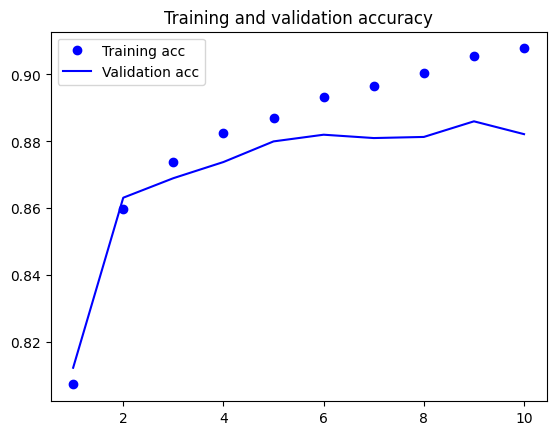

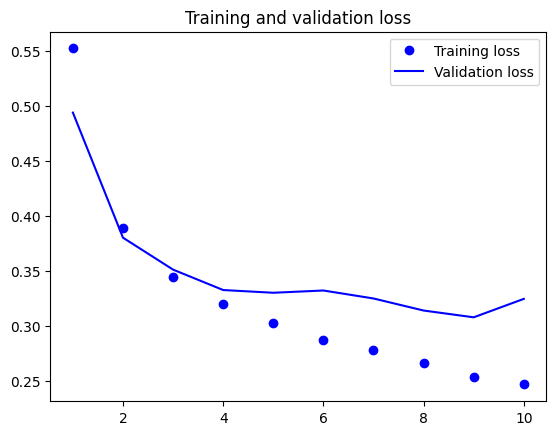

In [53]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 2s 4ms/step


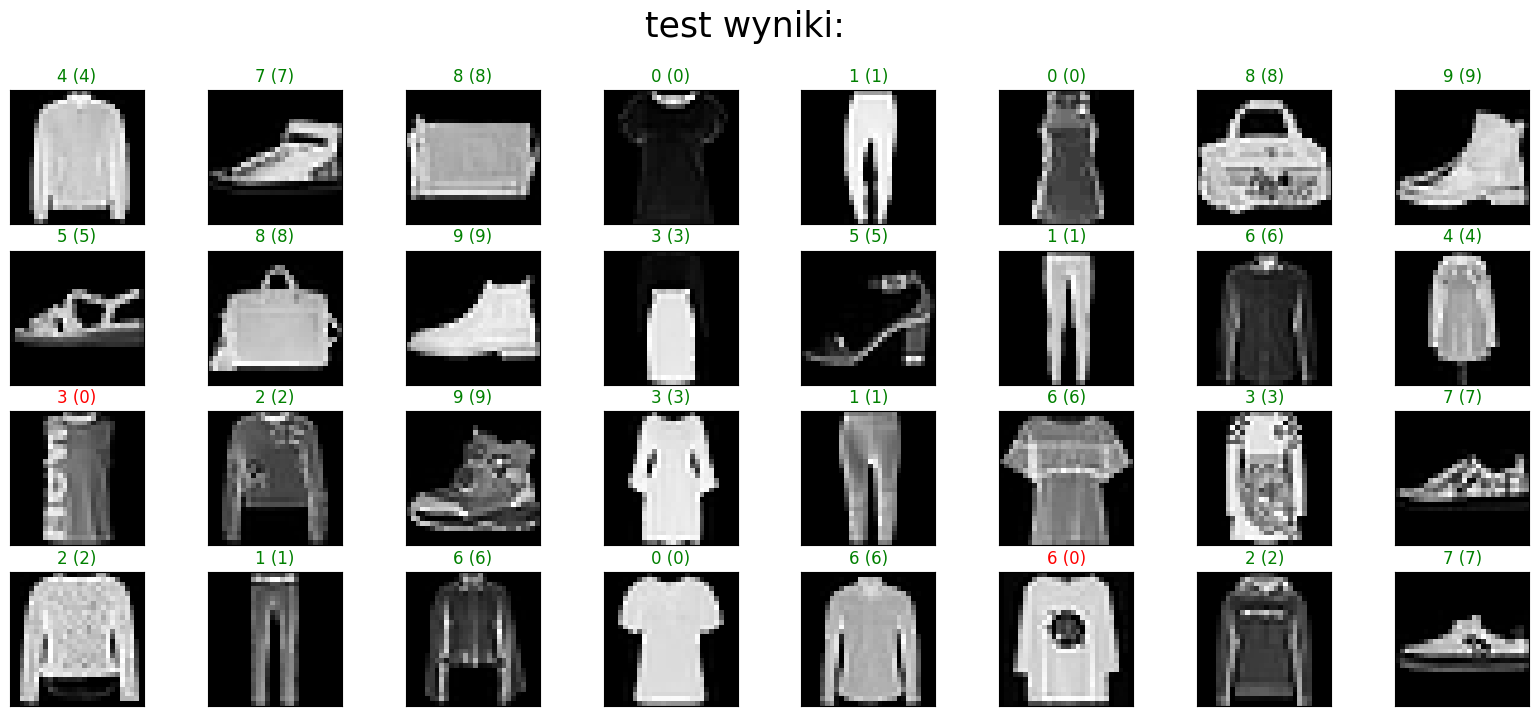

In [54]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Pogłębiamy model v3
Dodajmy 4 warstwy gęste.

In [55]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 10)               

Wykresy precyzji i błędu

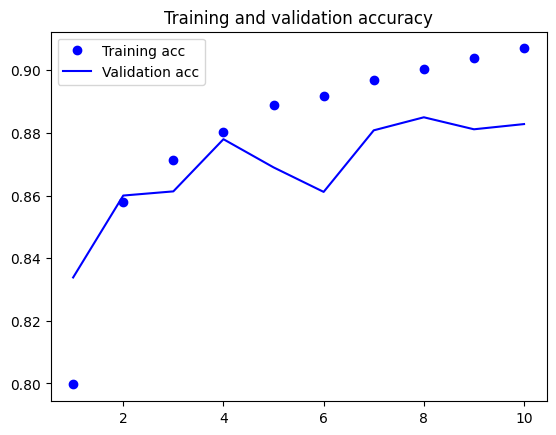

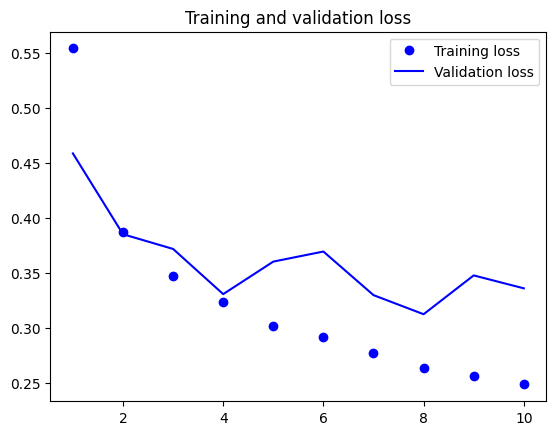

In [56]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


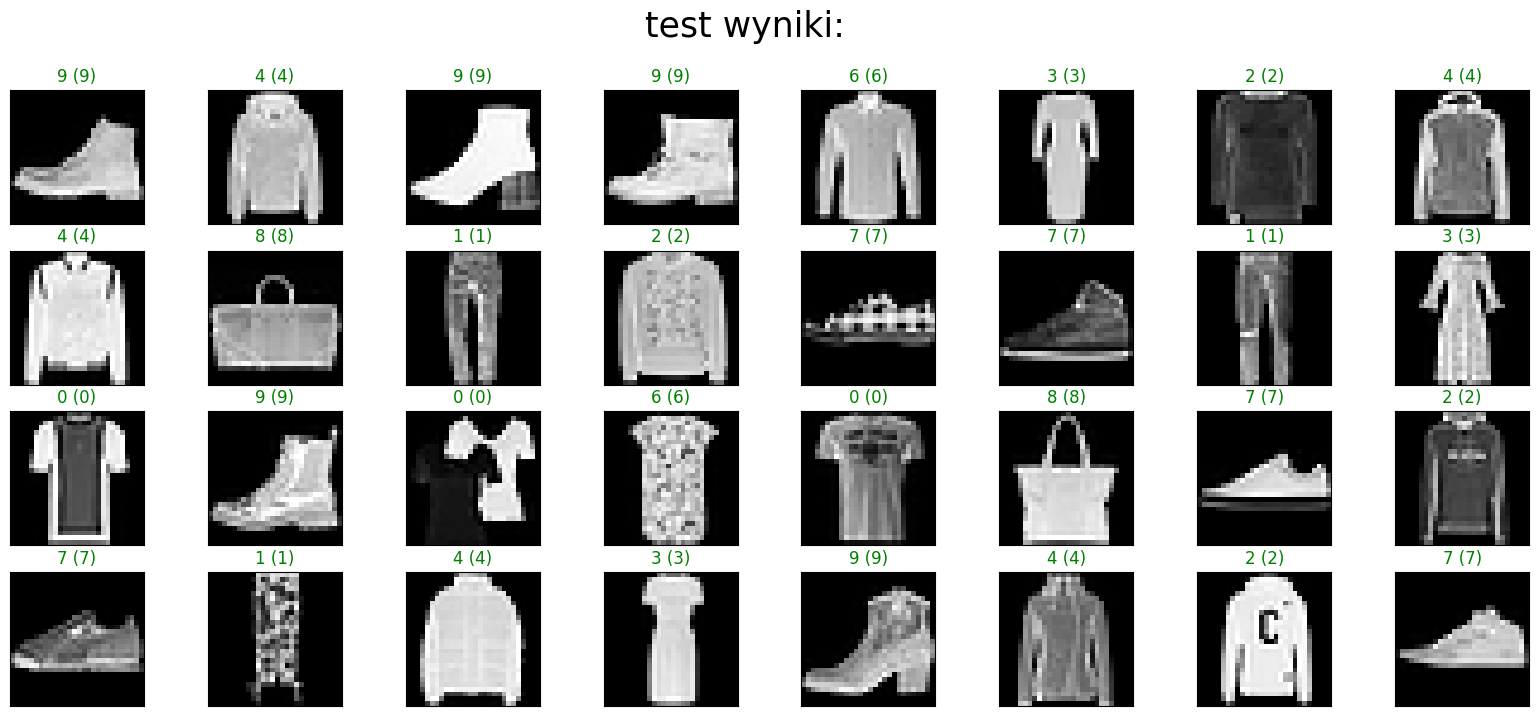

In [57]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.3 Konwolucja

W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [58]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         20        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 2)         34        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 2)           0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 98)                0         
                                                                 
 dense_24 (Dense)            (None, 128)              

In [59]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 5ms/step - loss: 0.8460 - accuracy: 0.6909 - val_loss: 0.5659 - val_accuracy: 0.7833
Epoch 2/25
422/422 [==============================] - 2s 4ms/step - loss: 0.5310 - accuracy: 0.8006 - val_loss: 0.4907 - val_accuracy: 0.8155
Epoch 3/25
422/422 [==============================] - 2s 4ms/step - loss: 0.4643 - accuracy: 0.8292 - val_loss: 0.4464 - val_accuracy: 0.8360
Epoch 4/25
422/422 [==============================] - 2s 4ms/step - loss: 0.4304 - accuracy: 0.8422 - val_loss: 0.4248 - val_accuracy: 0.8415
Epoch 5/25
422/422 [==============================] - 2s 4ms/step - loss: 0.4082 - accuracy: 0.8496 - val_loss: 0.4117 - val_accuracy: 0.8502
Epoch 6/25
422/422 [==============================] - 2s 5ms/step - loss: 0.3921 - accuracy: 0.8572 - val_loss: 0.3825 - val_accuracy: 0.8593
Epoch 7/25
422/422 [==============================] - 2s 6ms/step - loss: 0.3769 - accuracy: 0.8616 - val_loss: 0.3723 - val_accuracy: 0.8607
Epoch 

## Ewaluacja modelu

In [60]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.8812000155448914


Wykresy precyzji i błędu

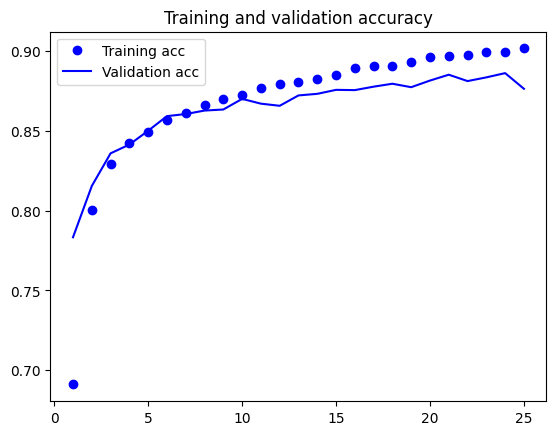

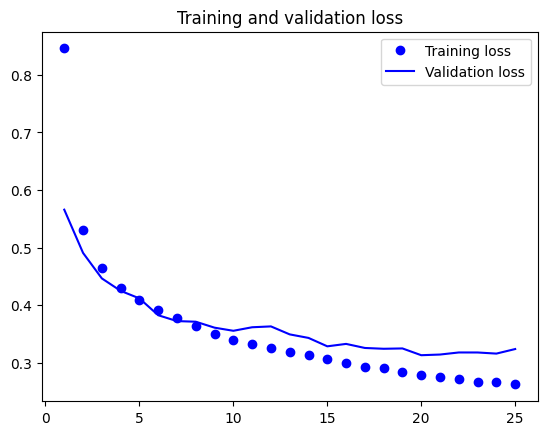

In [61]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


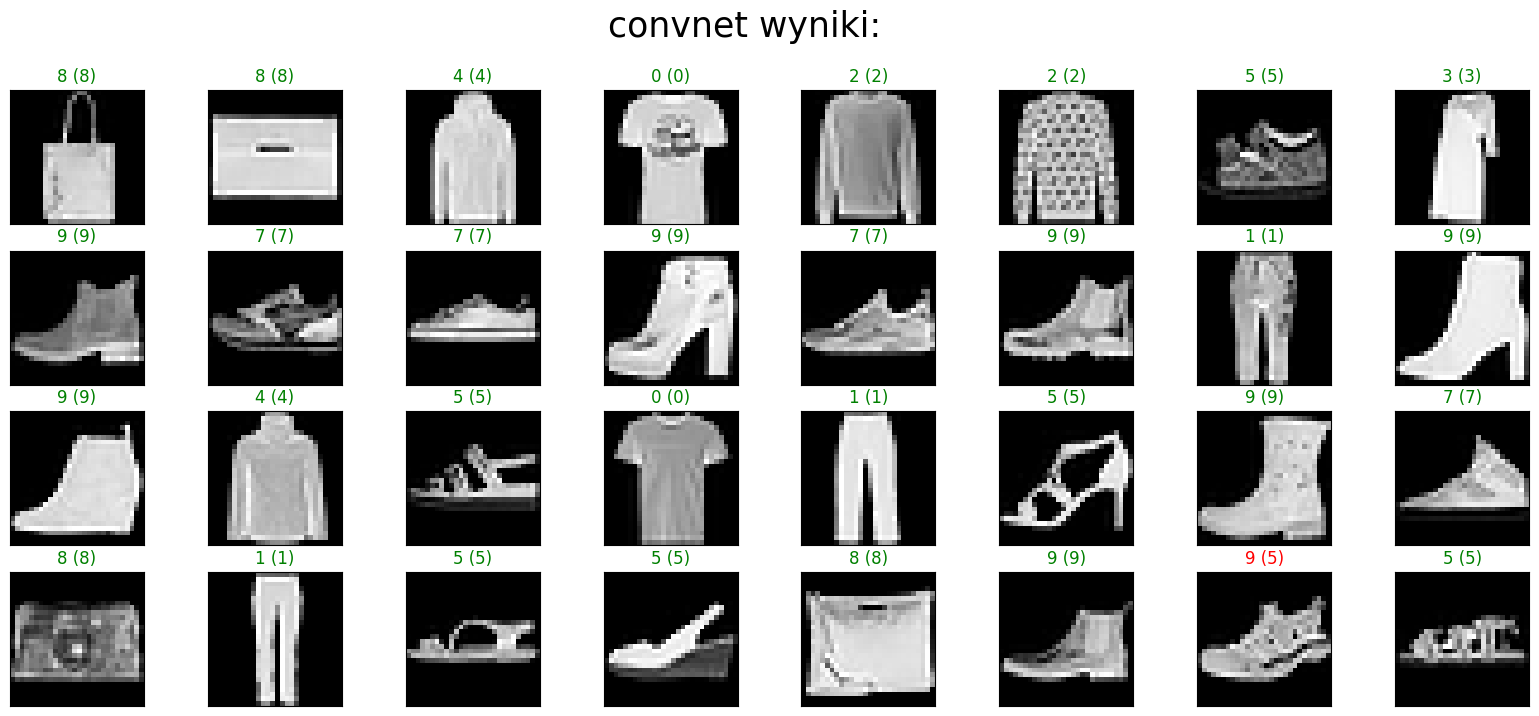

In [62]:
visualize_model_predictions(model, x_test, y_test,"convnet")

## 2.3 Konwolucja model v2
W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [63]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 4)         20        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 2)         34        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 2)           0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 2)           18        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 2)         

In [64]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 4s 5ms/step - loss: 1.1637 - accuracy: 0.5790 - val_loss: 0.7959 - val_accuracy: 0.6807
Epoch 2/25
422/422 [==============================] - 2s 5ms/step - loss: 0.7650 - accuracy: 0.7042 - val_loss: 0.6997 - val_accuracy: 0.7293
Epoch 3/25
422/422 [==============================] - 2s 5ms/step - loss: 0.6898 - accuracy: 0.7345 - val_loss: 0.6478 - val_accuracy: 0.7452
Epoch 4/25
422/422 [==============================] - 3s 6ms/step - loss: 0.6401 - accuracy: 0.7561 - val_loss: 0.5995 - val_accuracy: 0.7725
Epoch 5/25
422/422 [==============================] - 2s 5ms/step - loss: 0.6076 - accuracy: 0.7702 - val_loss: 0.5994 - val_accuracy: 0.7697
Epoch 6/25
422/422 [==============================] - 2s 5ms/step - loss: 0.5841 - accuracy: 0.7803 - val_loss: 0.5755 - val_accuracy: 0.7847
Epoch 7/25
422/422 [==============================] - 2s 5ms/step - loss: 0.5668 - accuracy: 0.7889 - val_loss: 0.5513 - val_accuracy: 0.7888
Epoch 

## Ewaluacja modelu

In [65]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.8307999968528748


Wykresy precyzji i błędu

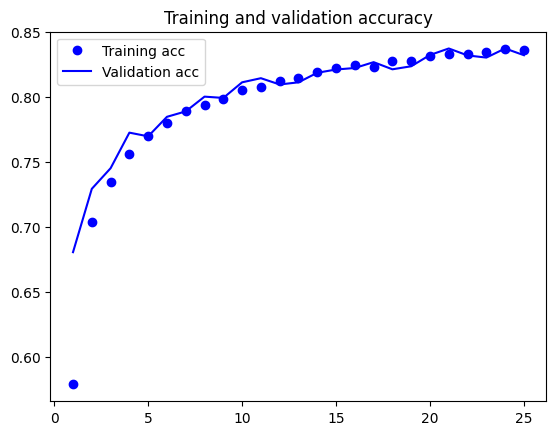

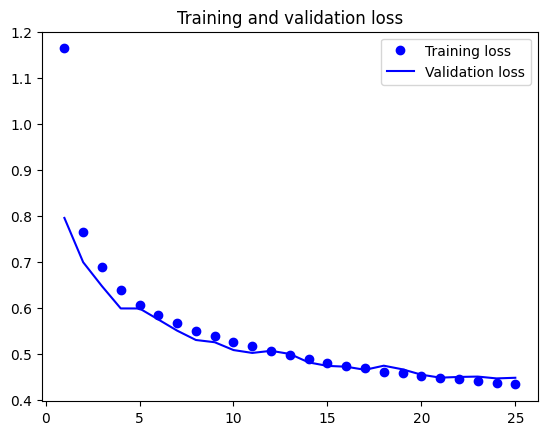

In [66]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


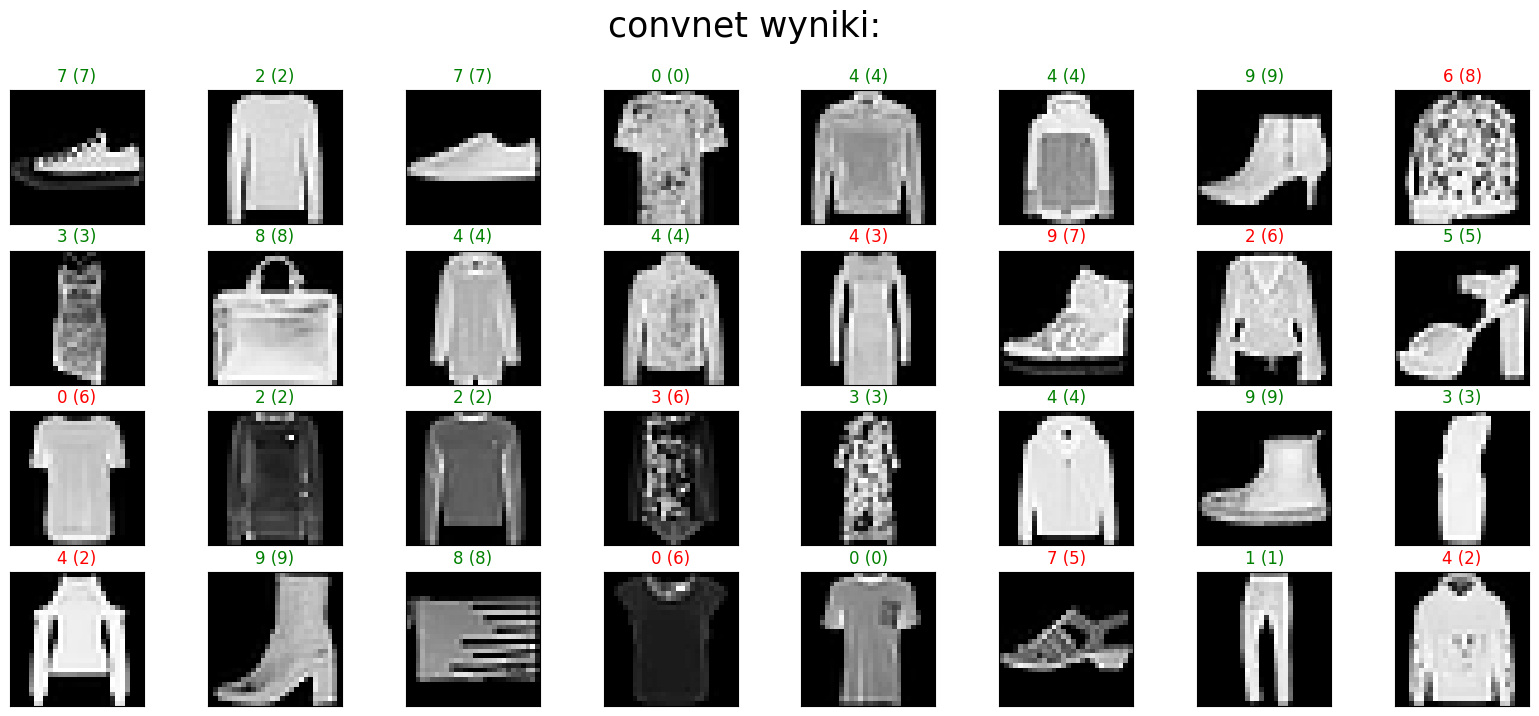

In [67]:
visualize_model_predictions(model, x_test, y_test,"convnet")

## 2.3 Konwolucja model v3
W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [68]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 16)          2064      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 3, 16)        

In [69]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 5s 7ms/step - loss: 0.7195 - accuracy: 0.7354 - val_loss: 0.4585 - val_accuracy: 0.8332
Epoch 2/25
422/422 [==============================] - 3s 7ms/step - loss: 0.4166 - accuracy: 0.8487 - val_loss: 0.4034 - val_accuracy: 0.8548
Epoch 3/25
422/422 [==============================] - 3s 6ms/step - loss: 0.3568 - accuracy: 0.8701 - val_loss: 0.3831 - val_accuracy: 0.8572
Epoch 4/25
422/422 [==============================] - 2s 6ms/step - loss: 0.3261 - accuracy: 0.8821 - val_loss: 0.3415 - val_accuracy: 0.8787
Epoch 5/25
422/422 [==============================] - 2s 6ms/step - loss: 0.3085 - accuracy: 0.8870 - val_loss: 0.3166 - val_accuracy: 0.8847
Epoch 6/25
422/422 [==============================] - 2s 6ms/step - loss: 0.2871 - accuracy: 0.8949 - val_loss: 0.2970 - val_accuracy: 0.8910
Epoch 7/25
422/422 [==============================] - 3s 7ms/step - loss: 0.2742 - accuracy: 0.8987 - val_loss: 0.2798 - val_accuracy: 0.9002
Epoch 

## Ewaluacja modelu

In [70]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9099000096321106


Wykresy precyzji i błędu

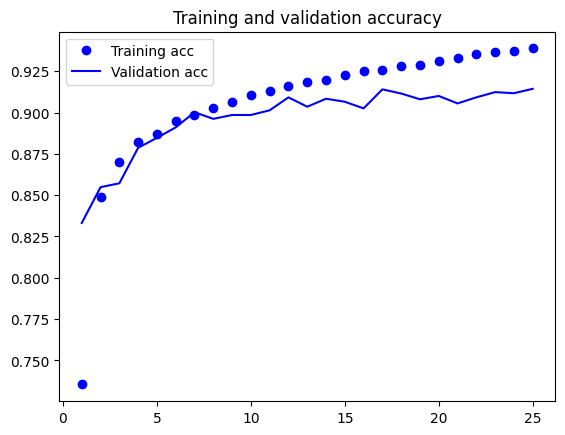

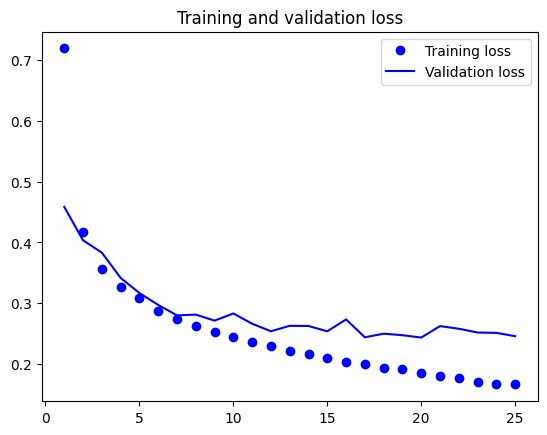

In [71]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


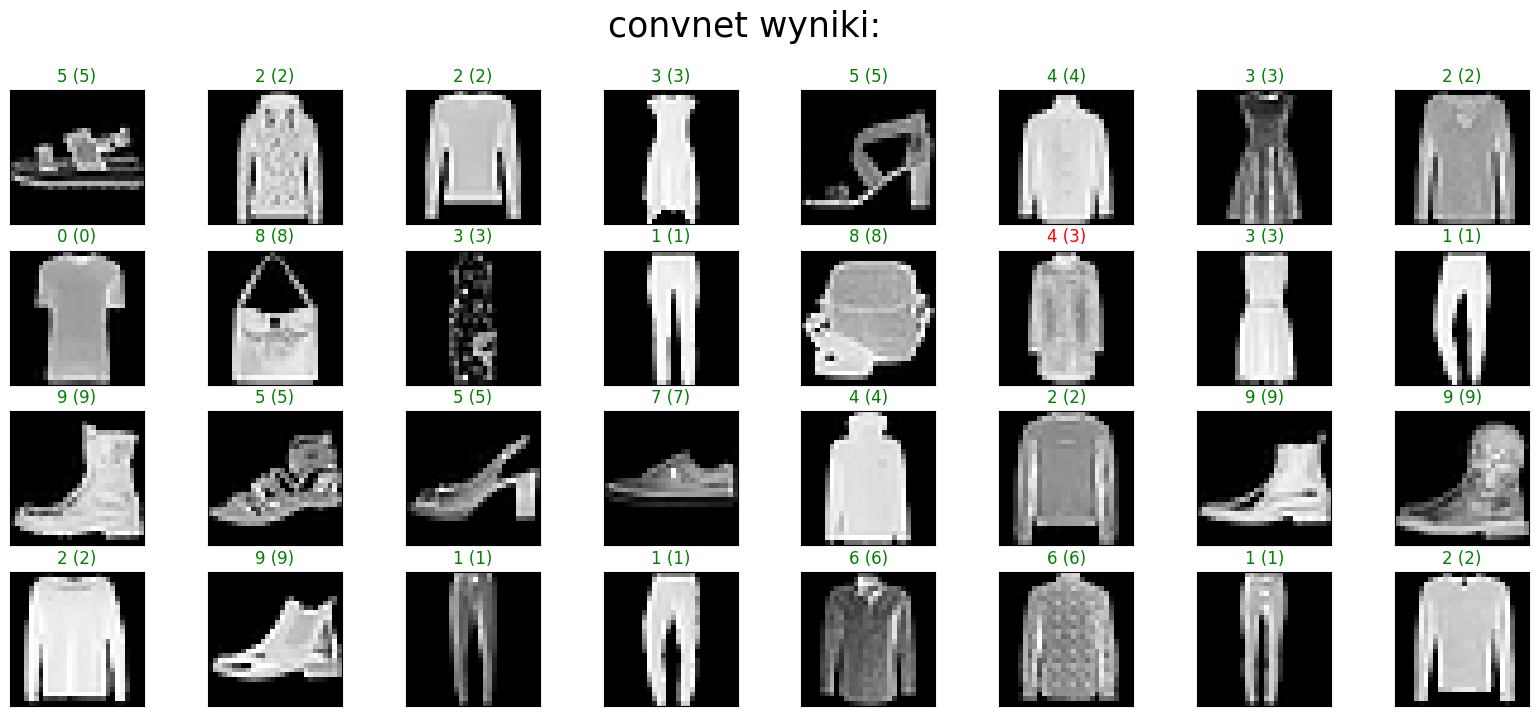

In [72]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy głównymi warstwami naszej sieci, aby uniknąć przeuczenia.

In [73]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)        

In [74]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 7s 9ms/step - loss: 0.8686 - accuracy: 0.6681 - val_loss: 0.5237 - val_accuracy: 0.8052
Epoch 2/25
422/422 [==============================] - 3s 8ms/step - loss: 0.5599 - accuracy: 0.7899 - val_loss: 0.4507 - val_accuracy: 0.8330
Epoch 3/25
422/422 [==============================] - 3s 8ms/step - loss: 0.5045 - accuracy: 0.8107 - val_loss: 0.3926 - val_accuracy: 0.8550
Epoch 4/25
422/422 [==============================] - 3s 7ms/step - loss: 0.4702 - accuracy: 0.8233 - val_loss: 0.3652 - val_accuracy: 0.8642
Epoch 5/25
422/422 [==============================] - 3s 7ms/step - loss: 0.4425 - accuracy: 0.8353 - val_loss: 0.3641 - val_accuracy: 0.8647
Epoch 6/25
422/422 [==============================] - 3s 8ms/step - loss: 0.4225 - accuracy: 0.8417 - val_loss: 0.3312 - val_accuracy: 0.8783
Epoch 7/25
422/422 [==============================] - 3s 8ms/step - loss: 0.4103 - accuracy: 0.8459 - val_loss: 0.3324 - val_accuracy: 0.8770
Epoch 

## Evaluate model:

In [75]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9166481494903564  Test accuracy:  0.9003000259399414


Wykresy precyzji i błędu

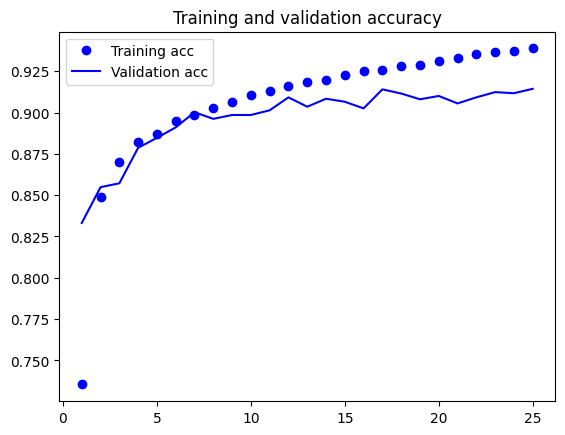

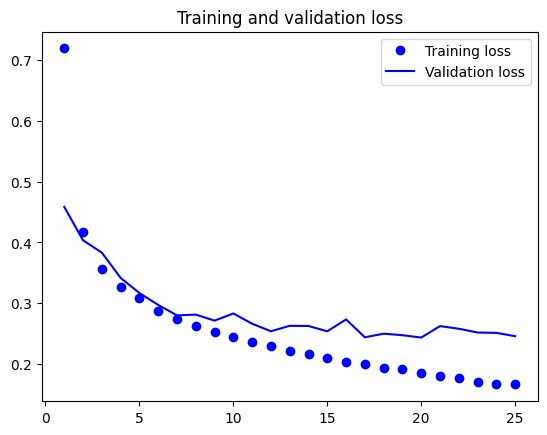

In [76]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


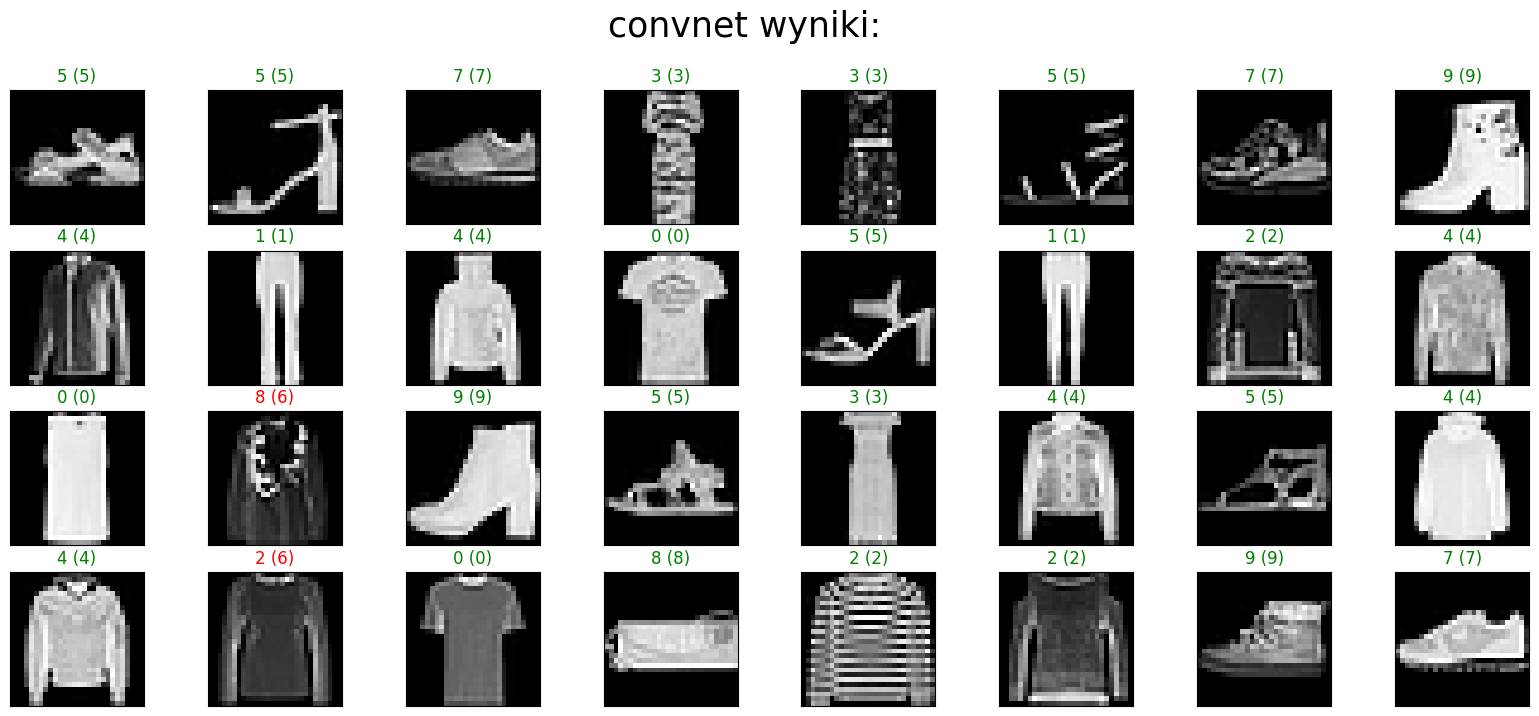

In [77]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja v2
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy warstwami naszej sieci, aby uniknąć przeuczenia.

In [78]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)        

In [79]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 9ms/step - loss: 0.8949 - accuracy: 0.6504 - val_loss: 0.5223 - val_accuracy: 0.7937
Epoch 2/25
422/422 [==============================] - 3s 8ms/step - loss: 0.5716 - accuracy: 0.7829 - val_loss: 0.4264 - val_accuracy: 0.8357
Epoch 3/25
422/422 [==============================] - 3s 7ms/step - loss: 0.5082 - accuracy: 0.8076 - val_loss: 0.3914 - val_accuracy: 0.8560
Epoch 4/25
422/422 [==============================] - 3s 7ms/step - loss: 0.4723 - accuracy: 0.8218 - val_loss: 0.3573 - val_accuracy: 0.8662
Epoch 5/25
422/422 [==============================] - 3s 8ms/step - loss: 0.4439 - accuracy: 0.8343 - val_loss: 0.3371 - val_accuracy: 0.8747
Epoch 6/25
422/422 [==============================] - 3s 8ms/step - loss: 0.4262 - accuracy: 0.8409 - val_loss: 0.3389 - val_accuracy: 0.8708
Epoch 7/25
422/422 [==============================] - 3s 7ms/step - loss: 0.4090 - accuracy: 0.8470 - val_loss: 0.3096 - val_accuracy: 0.8822
Epoch 

## Evaluate model:

In [80]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9178518652915955  Test accuracy:  0.9049000144004822


Wykresy precyzji i błędu

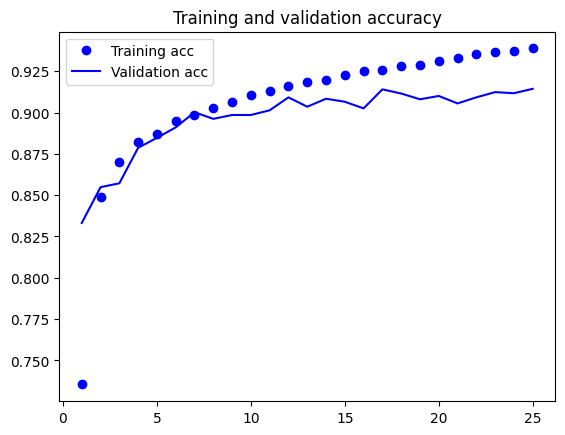

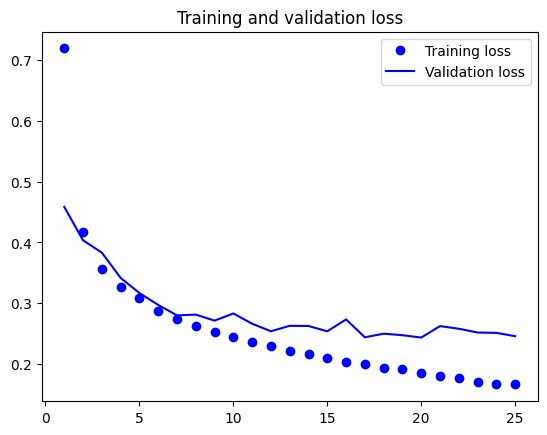

In [81]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


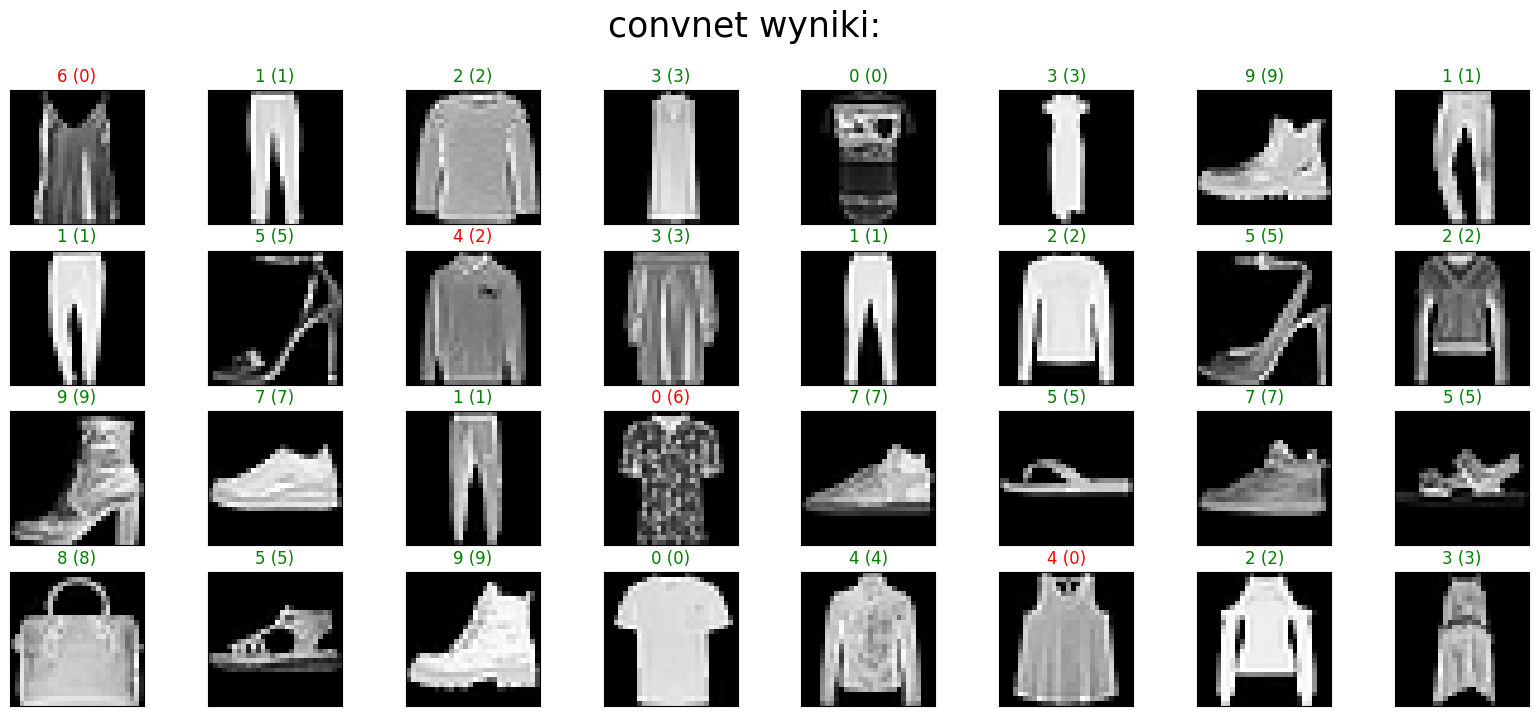

In [82]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja v3
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy warstwami naszej sieci, aby uniknąć przeuczenia.

In [112]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 7, 7, 32)        

In [113]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=60,
          validation_data=(x_valid, y_valid))

Epoch 1/60
422/422 [==============================] - 7s 12ms/step - loss: 0.8483 - accuracy: 0.6722 - val_loss: 0.5038 - val_accuracy: 0.8070
Epoch 2/60
422/422 [==============================] - 3s 8ms/step - loss: 0.5362 - accuracy: 0.7981 - val_loss: 0.4090 - val_accuracy: 0.8462
Epoch 3/60
422/422 [==============================] - 3s 8ms/step - loss: 0.4750 - accuracy: 0.8236 - val_loss: 0.3698 - val_accuracy: 0.8617
Epoch 4/60
422/422 [==============================] - 4s 9ms/step - loss: 0.4397 - accuracy: 0.8350 - val_loss: 0.3398 - val_accuracy: 0.8727
Epoch 5/60
422/422 [==============================] - 3s 8ms/step - loss: 0.4189 - accuracy: 0.8432 - val_loss: 0.3425 - val_accuracy: 0.8680
Epoch 6/60
422/422 [==============================] - 3s 8ms/step - loss: 0.4005 - accuracy: 0.8506 - val_loss: 0.3217 - val_accuracy: 0.8747
Epoch 7/60
422/422 [==============================] - 3s 8ms/step - loss: 0.3841 - accuracy: 0.8570 - val_loss: 0.3004 - val_accuracy: 0.8872
Epoch

## Evaluate model:

In [114]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9360185265541077  Test accuracy:  0.9124000072479248


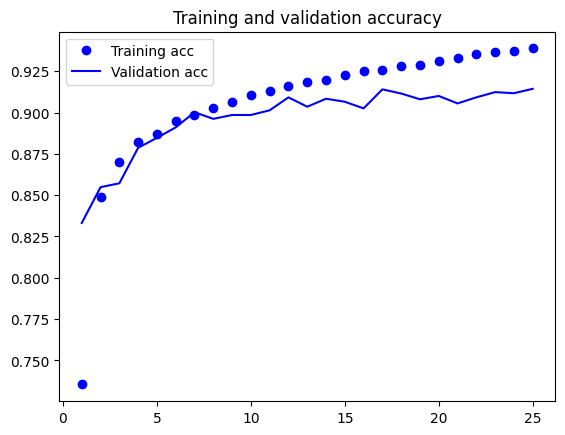

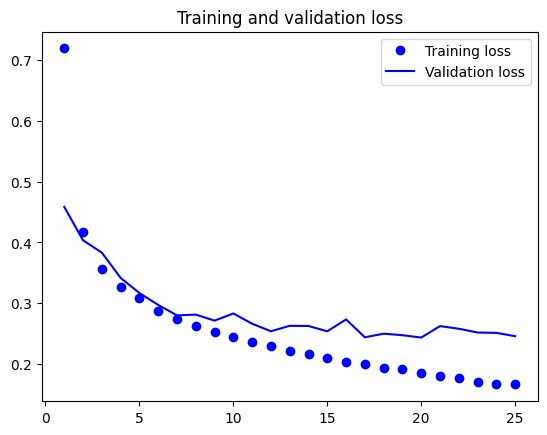

In [115]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


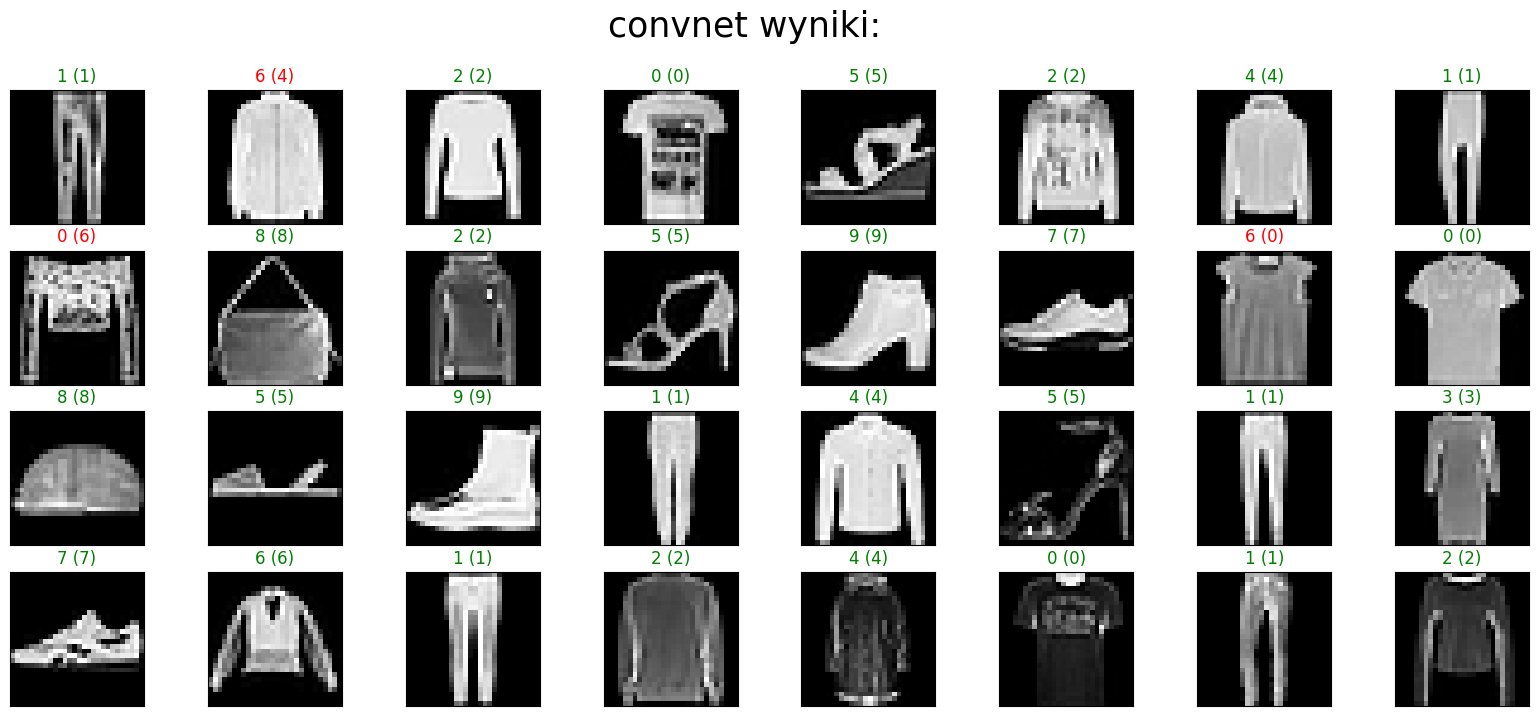

In [116]:
visualize_model_predictions(model, x_test, y_test,"convnet")

Wnioski

Najlepsze rezultaty uzyskuje model który stosuje konwolucję oraz regularyzacje w postaci warstw porzucających, ponieważ unika on wtedy przeuczenia. Najlepszym modelem jest model powyżej o nazwie Regularyzacja v3


```
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```



```
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=60,
          validation_data=(x_valid, y_valid))
```

